# Data Processiong

## Loading Data

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt



In [10]:
data = pd.read_csv('data/raw_survey_data_2022.csv',header=None)

In [11]:
# with sub-questions as header
df = pd.read_csv('data/raw_survey_data_2022.csv',header=1)

## Data cleaning

In [4]:
# Check if there are invalid responses 
# 1. the response column is correct (most essential:If you have read the survey up to this point, please select the number four (4). By selecting number 4, you'll be entered to win one of the prizes.)
# 2. response time more than 200s

In [12]:
## Finding the response question and their column indices
data.loc[0,data.iloc[0,:].str.contains('If you have read the survey up to this point')==True].index

Int64Index([176, 306], dtype='int64')

In [13]:
## 1 response column is correct
df_1=df[(df.iloc[:,176]=='2')&(df.iloc[:,306]=='4')]

In [14]:
## 2 response time more than 200s
def response_time(df,minimum=200):
    data1=df.iloc[:,1] #DataFrame with start time
    data2=df.iloc[:,2] #DataFrame with end time
    data3=df.iloc[:,3:] #DataFrame with data

    data3["time"]=data2.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))-data1.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
    #(data1.iloc[:,1].values.astype('datetime64[D]')-data1.iloc[:,0].values.astype('datetime64[D]'))

                                                                                                    
    index_time= data3["time"].apply(lambda x: x/np.timedelta64(1, 's'))
    data3['clean']=(index_time>200)
    cleaned_data=data3.loc[data3.clean==True].iloc[:,:-2]

    return cleaned_data
cleaned_data=response_time(df_1,200)

cleaned_data.shape

(1271, 348)

In [15]:
## change some answer to numerical
def numeric_scale(cleaned_data):
    for i in range(cleaned_data.shape[0]):
        for j in range(cleaned_data.shape[1]):
            if cleaned_data.iloc[i,j]=='Strongly agree':
                cleaned_data.iloc[i,j]=5
            if cleaned_data.iloc[i,j]=='Agree':
                cleaned_data.iloc[i,j]=4
            if cleaned_data.iloc[i,j]in['Neither agree or disagree','Neither agree nor disagree','Neither disagree nor agree']:
                cleaned_data.iloc[i,j]=3
            if cleaned_data.iloc[i,j]=='Disagree':
                cleaned_data.iloc[i,j]=2
            if cleaned_data.iloc[i,j]=='Strongly disagree':
                cleaned_data.iloc[i,j]=1
    return cleaned_data


cleaned_data=numeric_scale(cleaned_data)

##  Basic Statistics

In [9]:
##calculating the counts of each question

In [16]:
counts=[]
for i in range(len(cleaned_data.columns)):
    counts.append(dict(cleaned_data.iloc[:,i].value_counts()))


## Creating Question Table

In [17]:
# create the table of the first 2 rows to see the questions and the columns they locate
Q=data.iloc[:2,3:].T
Q.columns=['Question','Sub_Question']
#Q['location']=[ lambda x: x.index*(x.Question.isna()==False)]
Q=Q.reset_index(drop=True)
Q['location']=np.where(Q.Question.isna()==False, Q.Question.index, "False")
Q['counts']=counts

In [18]:
# Main questions
qq=Q[Q['location']!='False']
qq=qq.reset_index(drop=True)

In [19]:
Q.to_csv("output/Questions-22.csv", index=True)

In [20]:
pd.options.display.max_colwidth=120

In [15]:
Q.Question

0                                    I am satisfied with my overall experience at Columbia.
1      I am satisfied with the following with respect to my overall experience at Columbia.
2                                                                                       NaN
3                                                                                       NaN
4                                                                                       NaN
                                               ...                                         
343                                                                                     NaN
344                                                               What is your current age?
345                                                         Is English your first language?
346              Was English the medium of instruction in your primary or secondary school?
347           Let us know about other important matters that are not covered by 

## Find dataset for queryed text



In [21]:
##Find dataset for queryed text

def query_data(Q,qq,cleaned_data,query,indx):
    que=Q[Q['Question'].str.contains(query)==True]
    val=que.values
    ind=que.index.values
    print(Q.loc[ind[indx-1],'Question'])
    start=ind[indx-1]
    end=int(qq.iloc[qq[qq.location==str(ind[indx-1])].index+1]['location'])
    df_return=cleaned_data.iloc[:,start:end]
    return df_return



# Initial Analysis

## 1 How Satisfied are the SEAS students

In [22]:

query="satisfied"
indx=1  # the index of quetion you want to query among all questions that contains your query text, 
        # for example: I want to know the second question involves "satisfied", the indx is 2


df_satisfied = query_data(Q,qq,cleaned_data,query,indx=1)

I am satisfied with my overall experience at Columbia.


In [118]:
import matplotlib as mpl



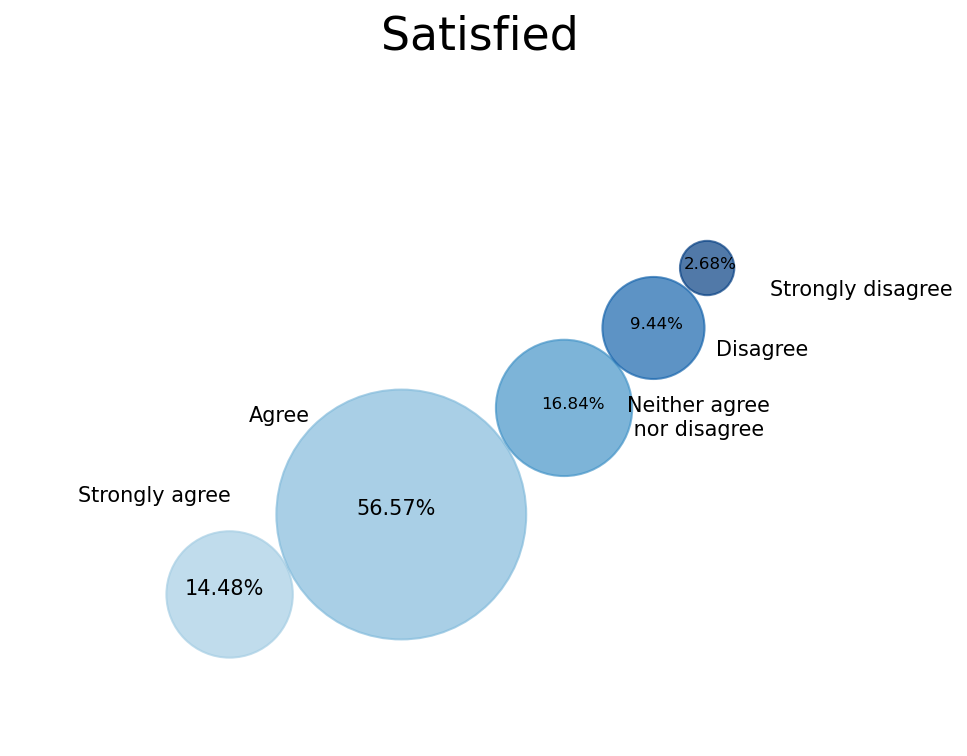

In [136]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']
a=(df_satisfied.Response.value_counts()).sort_index(ascending=False)

fig,ax0=plt.subplots(figsize=(8,6),dpi=150)

# use the scatterplot function to build the bubble map
#sns.scatterplot(x=[1,2,2.5,3,3.5], y=[0.9,1.5,1.84,1.9,2.5], size=a, legend=False, sizes=(200,20000),ax=ax0)
ax0.set_xlim([-0.2, 5.0])
ax0.set_ylim([-0.10, 5.0])
x=[1,1.96,2.87,3.37,3.67]
y=[1,1.6,2.4,3,3.45]
colors=[2.8,2.5,1.9,1.3,0.8]
sc=plt.scatter(x, y,s=a*20, c=colors, cmap=cmap,  alpha=0.7)
#plt.colorbar(sc)
for i in range(2):
    ax0.annotate(indd[i],(x[i]-0.85,y[i]+0.7))
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.25,y[i]-0))
for i in range(2,5):
    ax0.annotate(indd[i],(x[i]+0.35,y[i]-0.2))
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.13,y[i]-0),fontsize=8)
ax0.set_title("Satisfied",fontsize=22)



plt.axis('off')

# show the graph
plt.show()


## 2 Importance v.s. Satisfaction

In [24]:
df_important=query_data(Q,qq,cleaned_data,"important",indx=1)

The following are important with respect to my overall experience at Columbia.


In [25]:
df_satisfied2 = query_data(Q,qq,cleaned_data,"satisfied",indx=2)

I am satisfied with the following with respect to my overall experience at Columbia.


In [26]:
a=pd.DataFrame(df_satisfied2.mean()).T
b=pd.DataFrame(df_important.mean()).T
b.columns=a.columns
c2022=pd.concat([a,b],ignore_index=True)
c2022['Year']=2022

In [27]:
data_2019 = pd.read_csv('data/Copy of de-identified Graduate Student Quality of Life Survey - Spring 2019.xlsx - Graduate Student Quality of Lif.csv',header=1)

In [28]:
# use the same way to clean 2019 data
print(data_2019.shape)
cleaned_data_2019=response_time(data_2019,200)
cleaned_data_2019.shape

(1033, 345)


(997, 342)

In [29]:

d2019=numeric_scale(cleaned_data_2019)

In [30]:

df_satisfied2019=query_data(Q,qq,d2019,"satisfied",indx=2)
df_important2019=query_data(Q,qq,d2019,"important",indx=1)

I am satisfied with the following with respect to my overall experience at Columbia.
The following are important with respect to my overall experience at Columbia.


In [31]:
aa=pd.DataFrame(df_satisfied2019.mean()).T
bb=pd.DataFrame(df_important2019.mean()).T
bb.columns=aa.columns

c2019=pd.concat([aa,bb],ignore_index=True)
c2019['Year']=2019


In [32]:
c2019.columns=c2022.columns
cc=pd.concat([c2019,c2022],ignore_index=True)
cc

Academics  Mental health  Physical health  Professional development  \
0   3.993982       3.579739         3.669007                  3.839519   
1   4.538616       4.169509         4.183551                  4.324975   
2   3.883556       3.430370         3.530291                  3.675846   
3   4.597168       4.289536         4.210071                  4.332809   

   Social life  Career Placement Team   Housing  \
0     3.641926               3.648947  3.236710   
1     3.998997               4.299900  3.863591   
2     3.536585               3.260425  3.235248   
3     4.143981               4.274587  3.901652   

   Intercampus Shuttle/Via Service  Library services  Funding opportunities  \
0                         3.502508          4.125376               3.184554   
1                         3.304915          4.131394               3.953862   
2                         3.653029          4.084186               3.024390   
3                         3.804878          4.047994               4.009441   

   Student life and academic advising  Technology services and support  Year  
0                            3.744233                         3.898696  2019  
1                            4.248746                         4.056169  2019  
2                            3.484658                         3.713611  2022  
3                            4.313139                         3.985051  2022

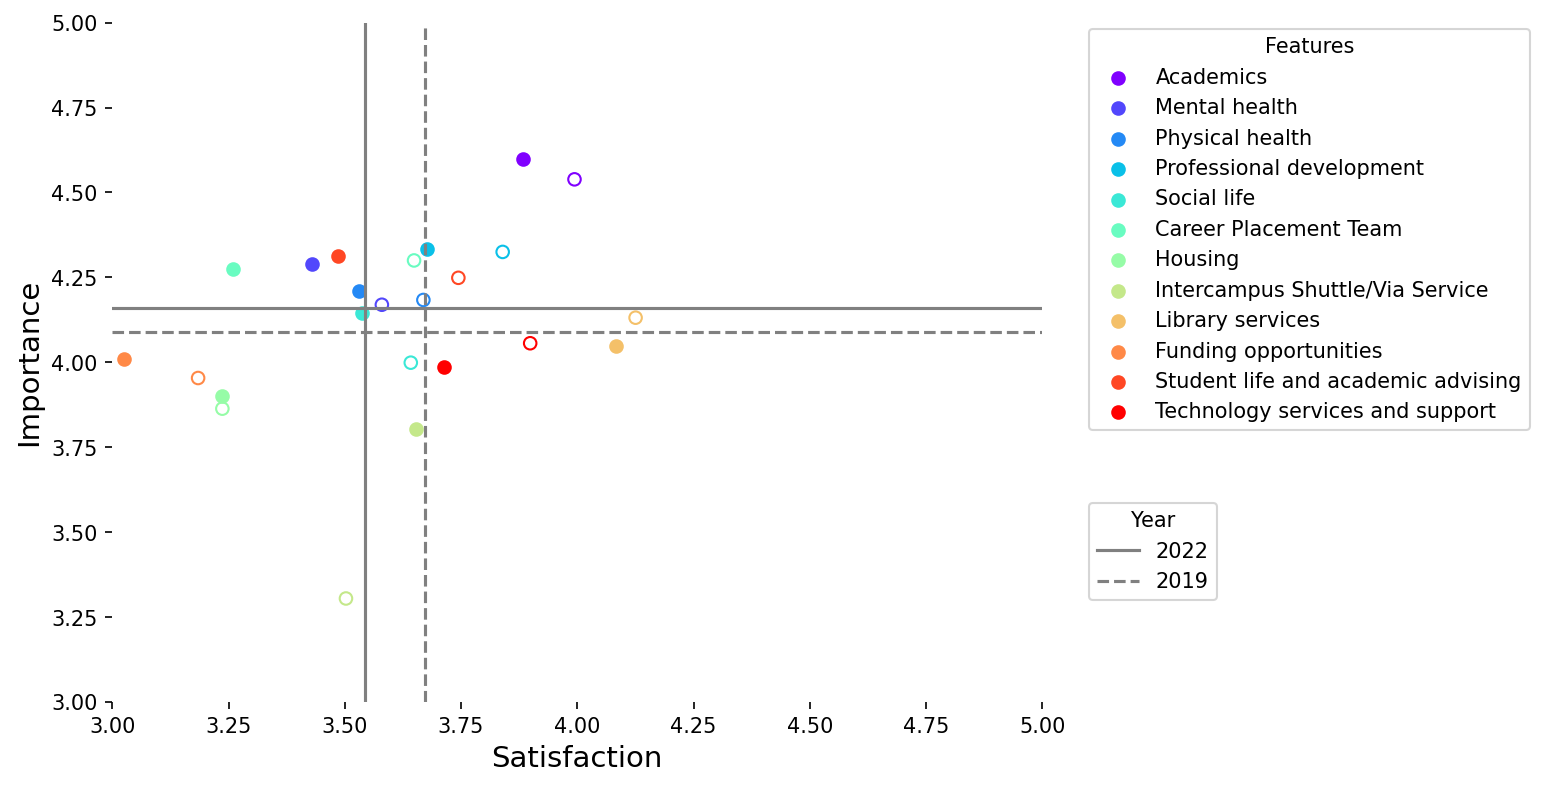

In [137]:
#plt.scatter(c.iloc[0,:],c.iloc[1,:])
import matplotlib.cm as cm


fig,ax=plt.subplots(figsize=(8,6),dpi=150)


colors = cm.rainbow(np.linspace(0, 1, (12)))

for i in range(12):
    ax.scatter(c2022.iloc[0,i], c2022.iloc[1,i],label=c2022.columns[i],c=colors[i].reshape(1,-1))

for i in range(12):
    ax.scatter(c2019.iloc[0,i], c2019.iloc[1,i],marker='o',facecolors='none',edgecolors=colors[i].reshape(1,-1))

line1=ax.axhline(y=c2022.iloc[1,:-1].mean(),c='grey')
ax.axvline(x=c2022.iloc[0,:-1].mean(),c='grey' )

line2=ax.axhline(y=c2019.iloc[1,:-1].mean(),c='grey',ls='--')
ax.axvline(x=c2019.iloc[0,:-1].mean(),c='grey' ,ls='--')


ax.set_xlim([3.0, 5.0])
ax.set_ylim([3.0, 5.0])


#ax.set_title("Importance vs Satisfaction for all features",fontsize=22)


#second_legend=plt.legend(c.columns,bbox_to_anchor=(1, 2.5))
#second_legend=plt.legend(c.columns,loc="upper left")

leg = plt.legend(loc=(1.05,0.4), title="Features")
ax.add_artist(leg)

#first_legend=plt.legend([line1,line2],['2022','2019'],bbox_to_anchor=(1, 1.05))
plt.legend(handles=[line1,line2], labels=['2022','2019'],loc=(1.05,0.15), title="Year")


ax.set_xlabel("Satisfaction",fontsize=14)
ax.set_ylabel("Importance",fontsize=14)

#for i,txt in enumerate(np.arange(12)):
 #   print(i,txt)
    #ax.annotate(txt,(c.columns[i]))
#for i in range(6,10):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i], c2022.iloc[1,i]))
#for i in range(0,2):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]+0.02, c2022.iloc[1,i]-0.035))
#for i in range(3,5):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]+0.02, c2022.iloc[1,i]-0.035))
#for i in range(2,3):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.38, c2022.iloc[1,i]-0.035))
#for i in range(5,6):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.28, c2022.iloc[1,i]-0.05))
#for i in range(10,11):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.48, c2022.iloc[1,i]+0.1))
#for i in range(11,12):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i], c2022.iloc[1,i]-0.05))
    
ax.axhline(y=c2022.iloc[1,:].mean())
ax.axvline(x=c2022.iloc[0,:].mean(),c='black' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()





## 3 Satisfaction on other basis

In [82]:
degree=query_data(Q,qq,cleaned_data,'Current Academic Program',indx=1)
department=query_data(Q,qq,cleaned_data,'current academic department',indx=1)
gender=query_data(Q,qq,cleaned_data,'gender',indx=3)
LGBTQ=query_data(Q,qq,cleaned_data,'LGBTQ',indx=1)
ethnic=query_data(Q,qq,cleaned_data,'ethnic',indx=1)
country=query_data(Q,qq,cleaned_data,'Country',indx=1)
age=query_data(Q,qq,cleaned_data,'age',indx=3)

Current Academic Program
What is your current academic department or institute?
Please indicate the gender(s) with which you identify (check all that apply):
Do you identify yourself as part of the LGBTQ community?
Please identify your ethnic background.
Country of Origin
What is your current age?


## Satisfation by Gender

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


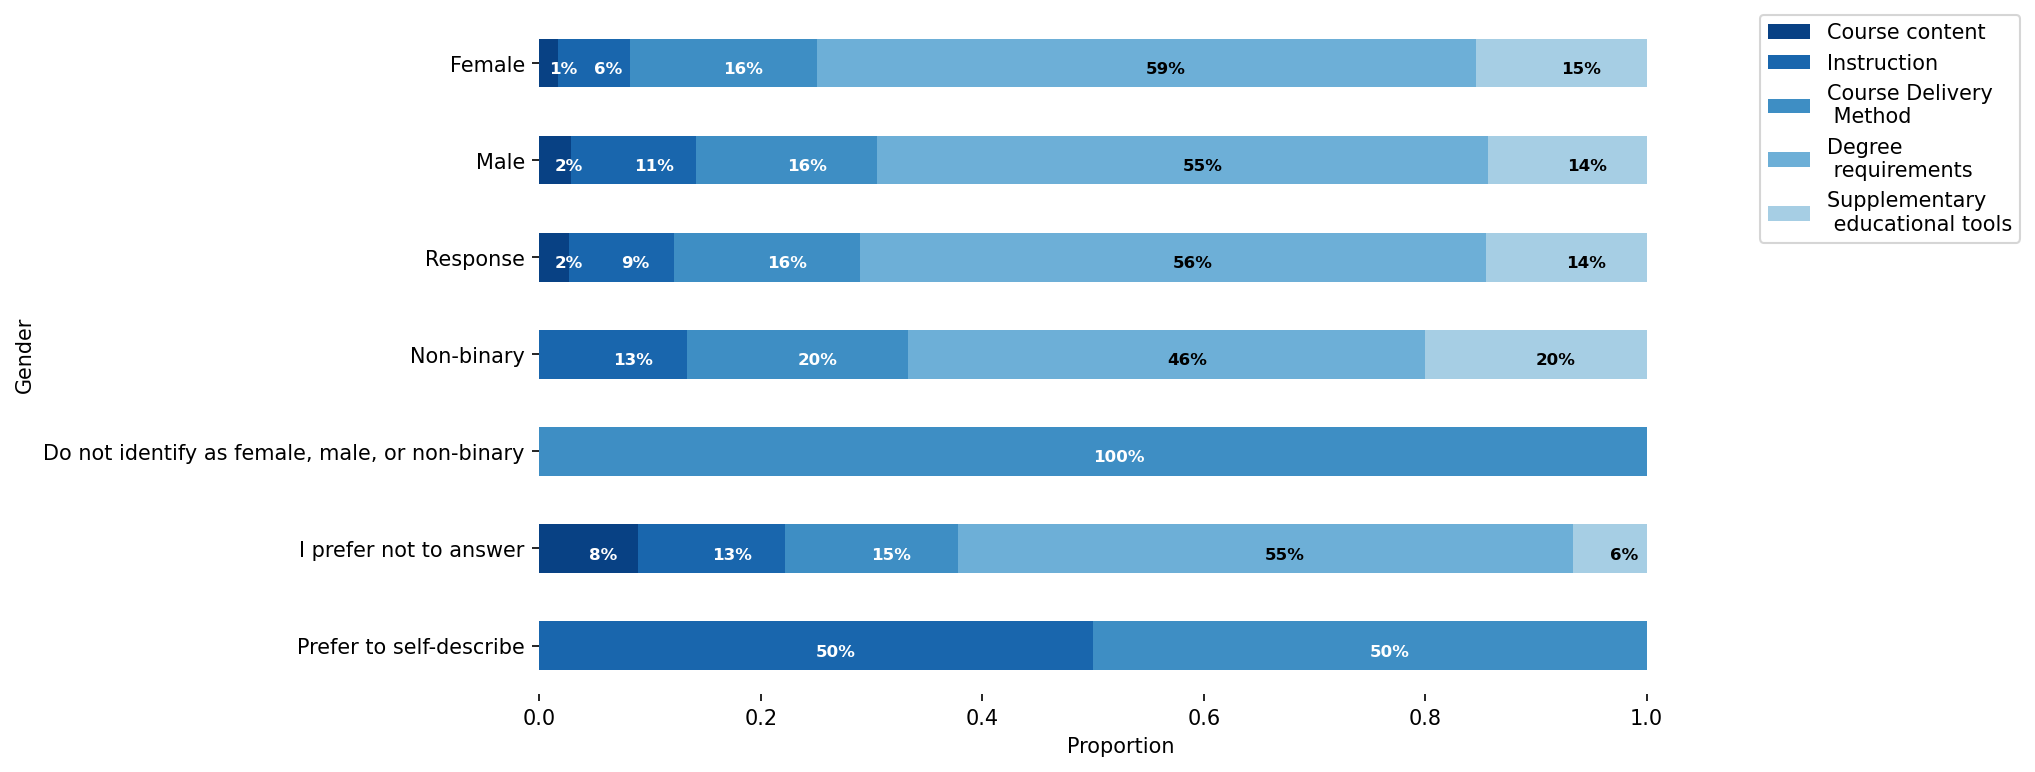

In [731]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


df_satisfied_gender=df_satisfied.copy()
df_satisfied_gender=df_satisfied_gender.join(gender)

gender_c=['Female','Male','Response','Non-binary','Do not identify as female, male, or non-binary','I prefer not to answer','Prefer to self-describe']
b=pd.DataFrame(columns=gender_c) 
for i in gender_c:
    data_used=df_satisfied_gender.loc[df_satisfied_gender[i].isna()!=True,'Response']
    b[i]=(pd.DataFrame(data_used.value_counts()).fillna(0)/pd.DataFrame(data_used).count(axis=0)*100)
    #print(pd.DataFrame(data_used).count(axis=0))  
 #b.append(a)

b=b[b.columns[::-1]]
b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b.sort_index().T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Gender")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Gender",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## Satisfaction By Degree

In [350]:
df_satisfied_degree=df_satisfied.copy()
df_satisfied_degree['degree']=degree
df_satisfied_degree['num']=1
dff=df_satisfied_degree.groupby(['degree','Response']).count().unstack('degree')
df_degree=dff['num']#/dfff.sum(axis=0)
#dff.to_csv("output/df_satisfied_degree.csv")
#df_degree=dff['num'].drop(columns='Professional Degree')
df_degree=df_degree.fillna(0)
#df_satisfied_degrea['Response']=df_satisfied_degree.Response.astype(int)
inner=df_satisfied_degree.groupby(['degree','Response']).sum()
outer = df_satisfied_degree.groupby('degree').sum()
outer

num
degree                           
Doctor of Philosophy (Ph.D.)  208
M.S. leading to Ph.D.          74
Master of Science (M.S.)      988
Professional Degree             1

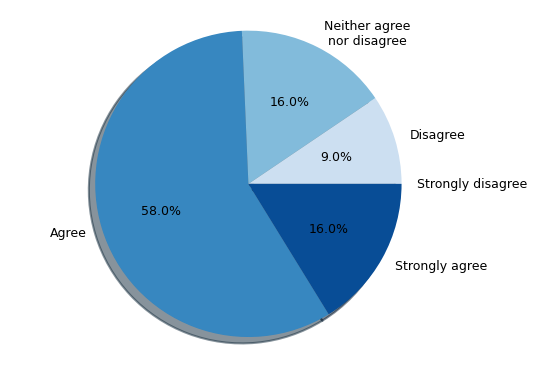

In [354]:
# Create a pieplot

fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
cmap = mpl.cm.Blues(np.linspace(0,2,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

explode = (0, 0, 0, 0,0) 
_, _, autotexts =ax.pie(df_degree['M.S. leading to Ph.D.'], explode=explode, labels=indd[::-1], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
        shadow=True,textprops={'fontsize': 6})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


posx and posy should be finite values
posx and posy should be finite values


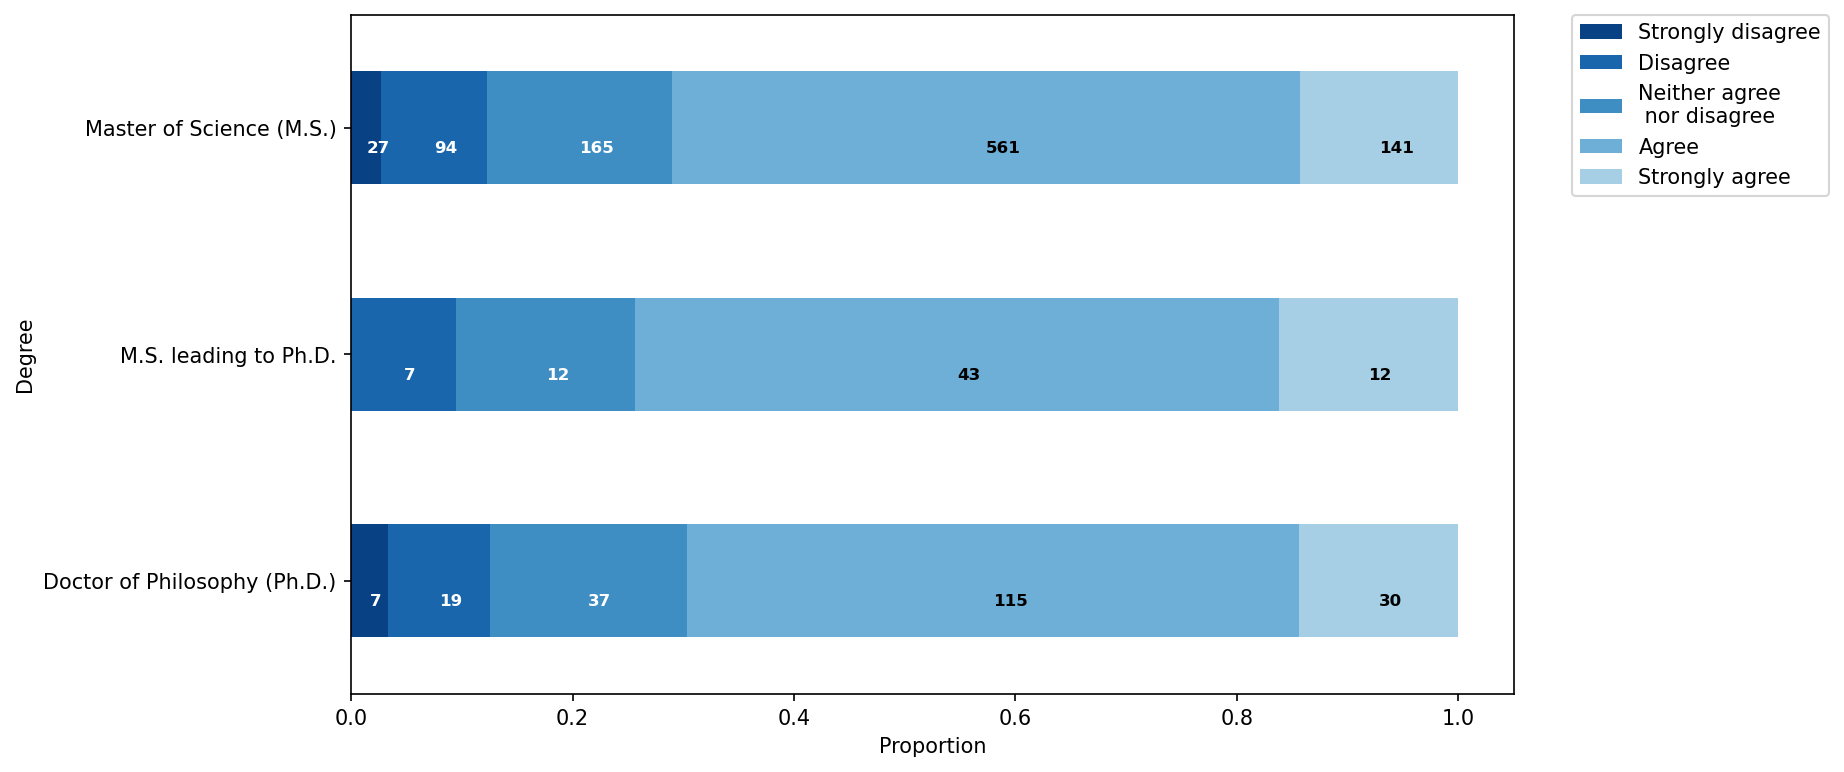

In [142]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


b_prob=df_degree.apply(lambda x: x / x.sum(), axis=0)
aaa=df_degree.T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Degree")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

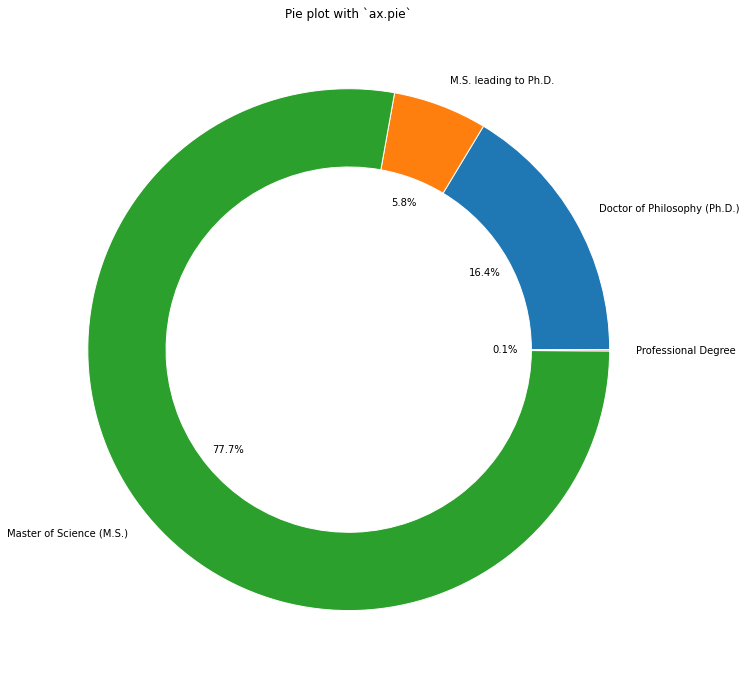

In [335]:
fig, ax = plt.subplots(figsize=(24,12))
size = 0.3

ax.pie(outer.values.flatten(), radius=1,
       labels=outer.index,
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

#ax.pie(inner.values.flatten(), radius=1-size, 
#       labels = inner_labels,
#       wedgeprops=dict(width=size, edgecolor='w'),colors=cmap)

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

## Satisfaction by Department

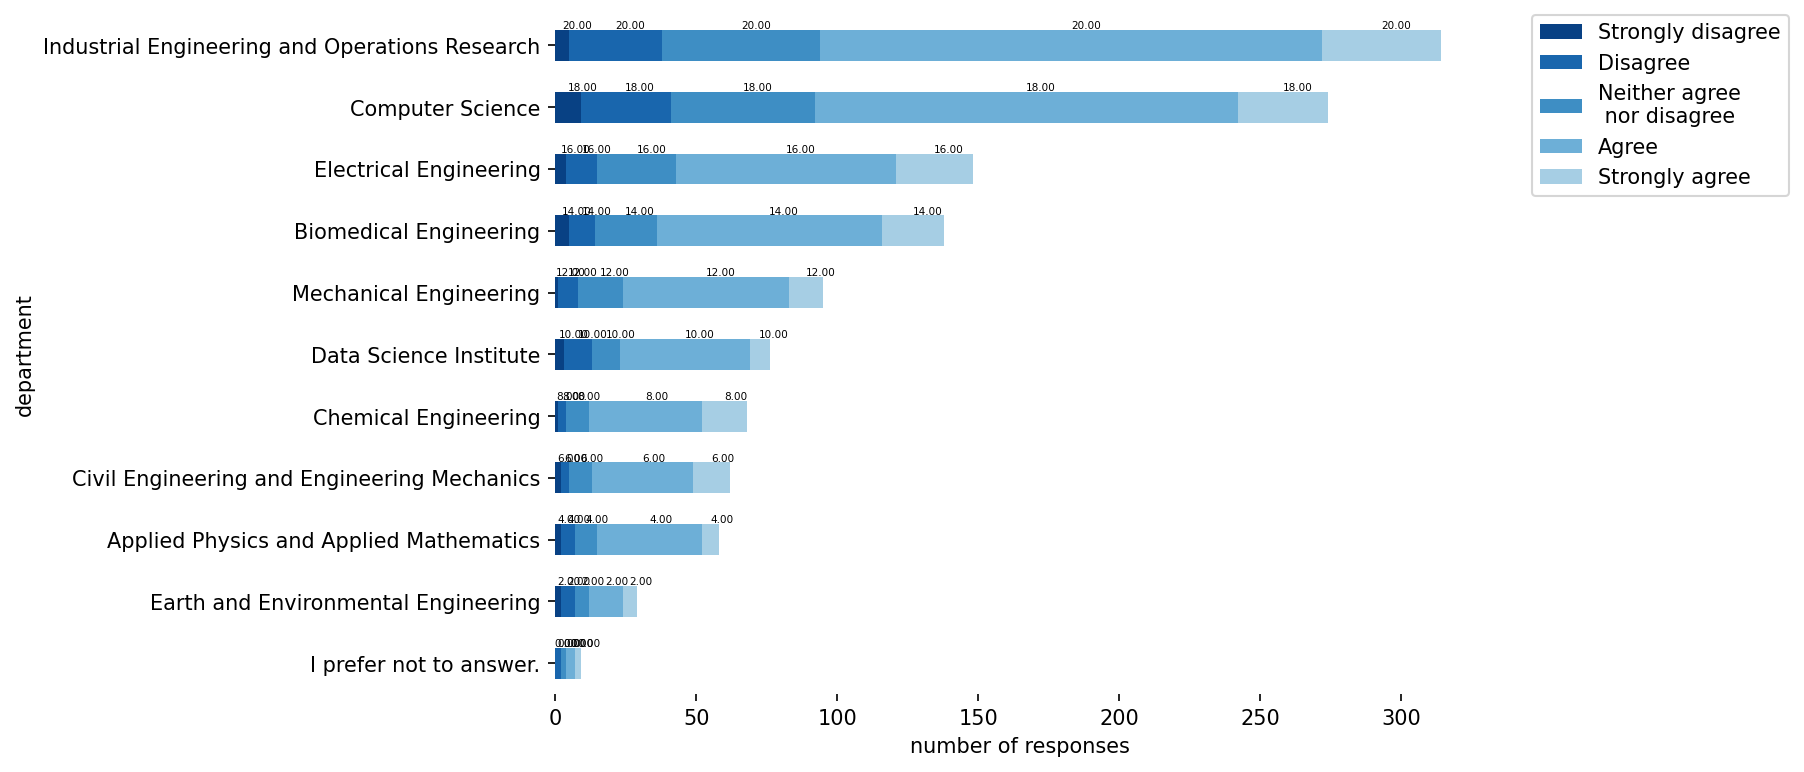

In [530]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
dff=df_satisfied_department.groupby(['department','Response']).count().unstack('department')
#/dfff.sum(axis=0)
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']


#dff.to_csv("output/df_satisfied_degree.csv")
df_department=dff['num']
df_department.fillna(0)
df_d=df_department[(df_department.sum(axis=0)).sort_values().index]


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
df_d.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(8,6),ax=ax)
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)



ax.set_xlabel("number of responses")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



## Academics


In [386]:
aca_import=query_data(Q,qq,cleaned_data,"academics",indx=1)


The following are important with respect to my overall satisfaction with SEAS classes and academics.


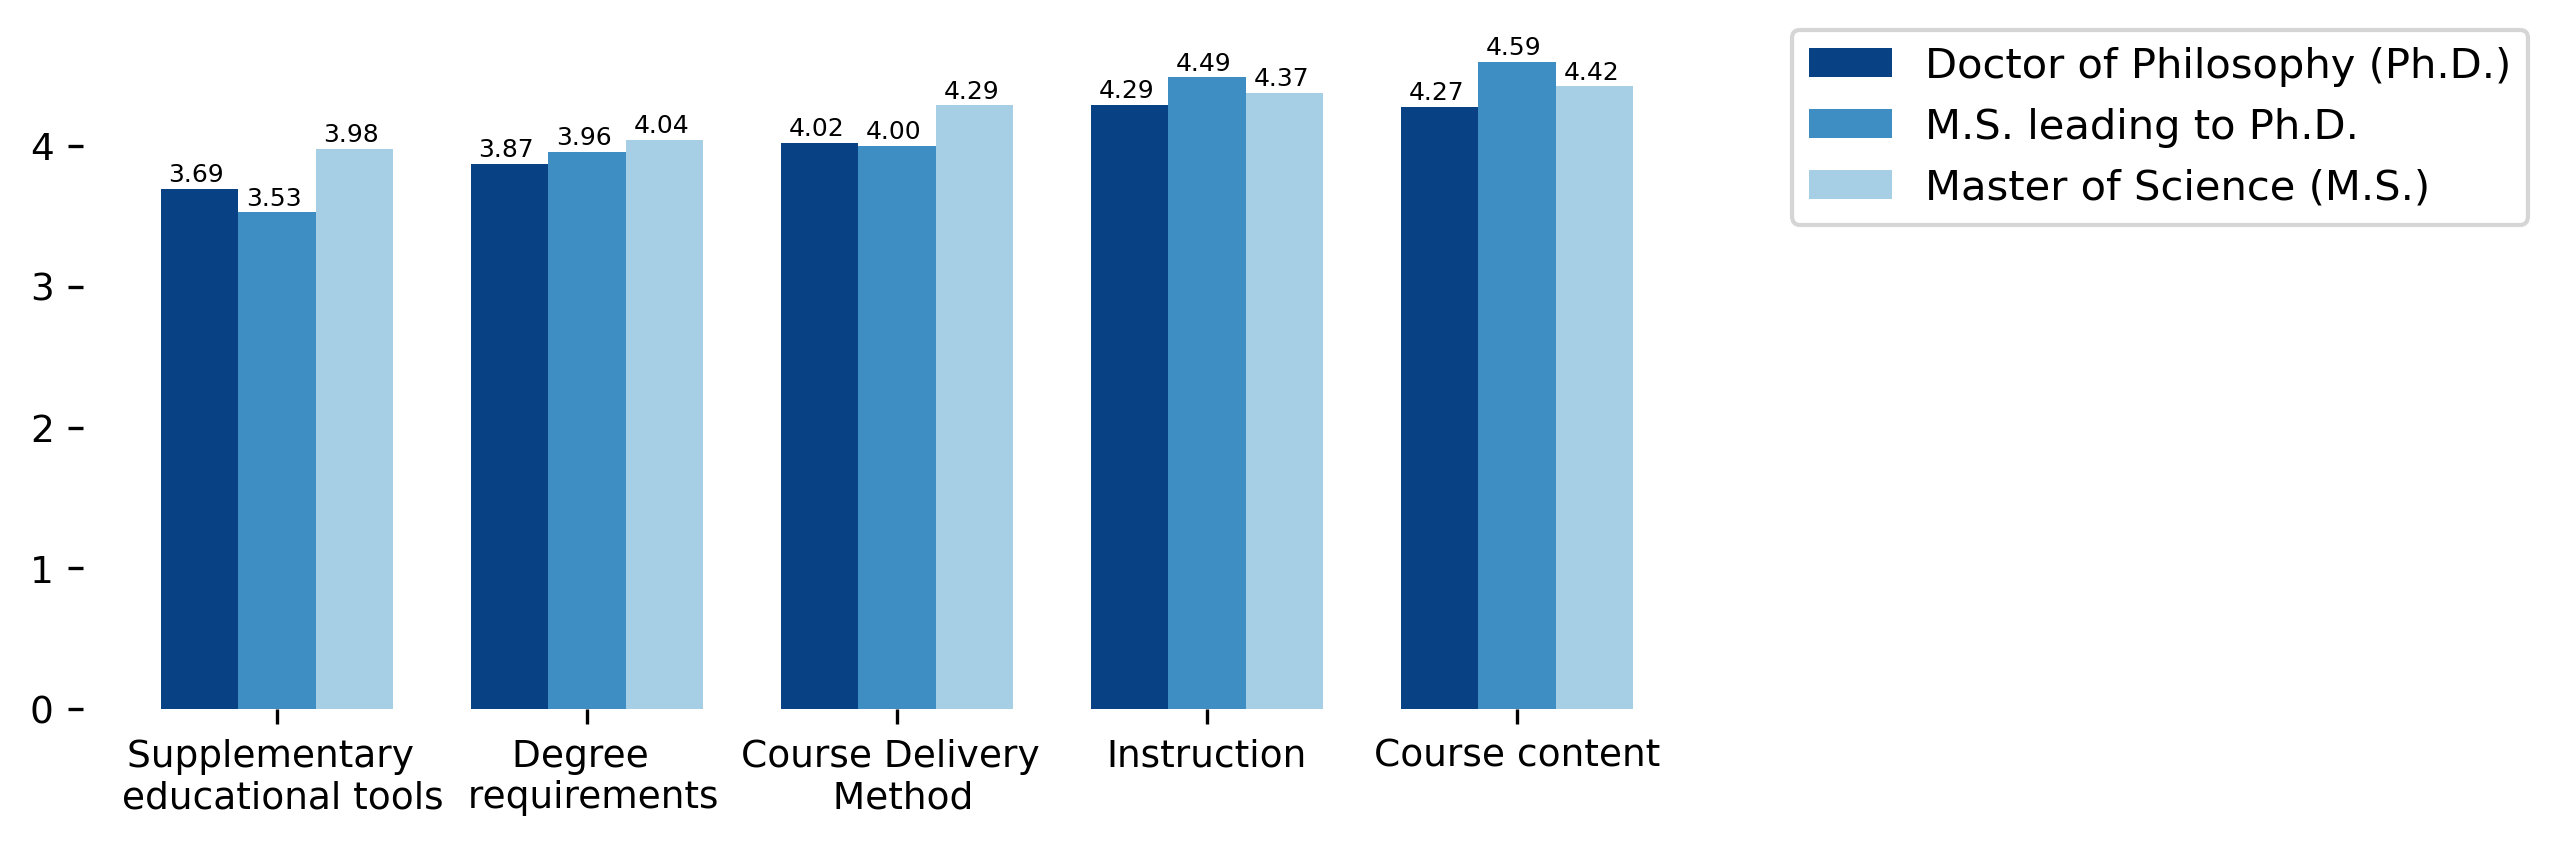

In [559]:
fig,ax=plt.subplots(figsize=(7,3),dpi=300)
aca_import['degree']=degree
df=aca_import.groupby(['degree']).mean().drop(index='Professional Degree')
df=df[df.sum().sort_values().index]
indd=['Supplementary \n educational tools', 'Degree \n requirements',
       'Course Delivery \n Method', 'Instruction', 'Course content']
ax=df.T.plot.bar(ax=ax,colormap=cmap,width=0.75, rot=0 ,fontsize=9)
ax.set_xticklabels(indd, rotation=0,)
x_offset = -0.1
y_offset = 0.05
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [349]:
query_data(Q,qq,cleaned_data,"academics",indx=2).columns

Please answer the following with respect to SEAS classes and academics.


Index(['The overall teaching quality of the lecturer was satisfactory:',
       'Theory and practical application were well-balanced:',
       'The course load was manageable:',
       'The availability of courses to satisfy degree requirements was satisfactory:',
       'There was a wide selection of  elective courses available:',
       'My degree requirements allowed me to take enough elective courses to tailor my education:',
       'The online course descriptions were available and accurate:',
       'The department websites are informative and easy to use:',
       'The degree requirements were clearly communicated at the start of the program:',
       'My coursework provided adequate preparation for my desired career choice:',
       'There were frequent academic and professional seminars of high quality:',
       'The Teaching Assistants (TA) were well equipped to help students with the course content:',
       'The Teaching Assistants (TA) conducted themselves responsibly:',
 

## PDL

In [334]:
PDL_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=3)
PDL_sat.value_counts()

I am satisfied with the PDL Core Modules.


Response.6
4             512
5             213
3             137
2              69
1              42
dtype: int64

In [669]:
PDL=query_data(Q,qq,cleaned_data,"PDL",indx=1)
PDL.value_counts()

Did you attend the Professional Development and Leadership (PDL) Program?


Response.5
Yes           973
No             15
dtype: int64

In [670]:
PDLe_sat=query_data(Q,qq,cleaned_data,"PDL",indx=3)
PDLe_sat.value_counts()

I am satisfied with the PDL Elective Modules.


Response.7
4             495
5             215
3             155
2              65
1              43
dtype: int64

In [324]:
df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
dff=df_satisfied_department.groupby(['department','Response']).count().unstack('department')
#/dfff.sum(axis=0)
inddd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Unaware of this resource']



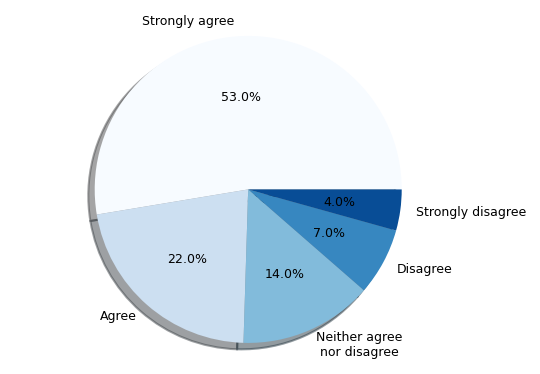

In [363]:
fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
cmap = mpl.cm.Blues(np.linspace(0,2,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

explode = (0, 0, 0, 0,0) 
_, _, autotexts =ax.pie(PDL_sat.value_counts(), explode=explode, labels=indd, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
        shadow=True,textprops={'fontsize': 6})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



In [672]:
skill=query_data(Q,qq,cleaned_data,"skills",indx=1)
skill


The following skills have been improved/enhanced by my time at Columbia SEAS.


Presentation skills Non-technical writing skills  \
0                      4                            4   
2                      1                            1   
5                      4                            2   
6                      4                            4   
7                      3                            3   
...                  ...                          ...   
1585                   3                            3   
1586                   5                            5   
1587                   4                            4   
1588                   3                            4   
1590                   1                            1   

     Technical writing skills Time management  \
0                           4               5   
2                           1               1   
5                           3               4   
6                           4               4   
7                           4               3   
...                       ...             ...   
1585                        4               3   
1586                        5               5   
1587                        4               4   
1588                        4               4   
1590                        1               1   

     Proficiency and expertise in my field Working in a team  \
0                                        4                 4   
2                                        1                 1   
5                                        5                 4   
6                                        4                 4   
7                                        3                 4   
...                                    ...               ...   
1585                                     4                 4   
1586                                     5                 5   
1587                                     5                 4   
1588                                     4                 4   
1590                                     1                 1   

     Interacting with Industry professionals Leadership skills  \
0                                          4                 4   
2                                          4                 1   
5                                          3                 2   
6                                          4                 4   
7                                          2                 3   
...                                      ...               ...   
1585                                       4                 4   
1586                                       5                 5   
1587                                       4                 4   
1588                                       4                 4   
1590                                       1                 1   

     Facilitating conversations and discussions  \
0                                             4   
2                                             1   
5                                             4   
6                                             4   
7                                             4   
...                                         ...   
1585                                          4   
1586                                          5   
1587                                          4   
1588                                          3   
1590                                          1   

     Keeping up with latest advances in my field  
0                                              4  
2                                              1  
5                                              2  
6                                              4  
7                                              3  
...                                          ...  
1585                                           3  
1586                                           5  
1587                                           4  
1588                                          

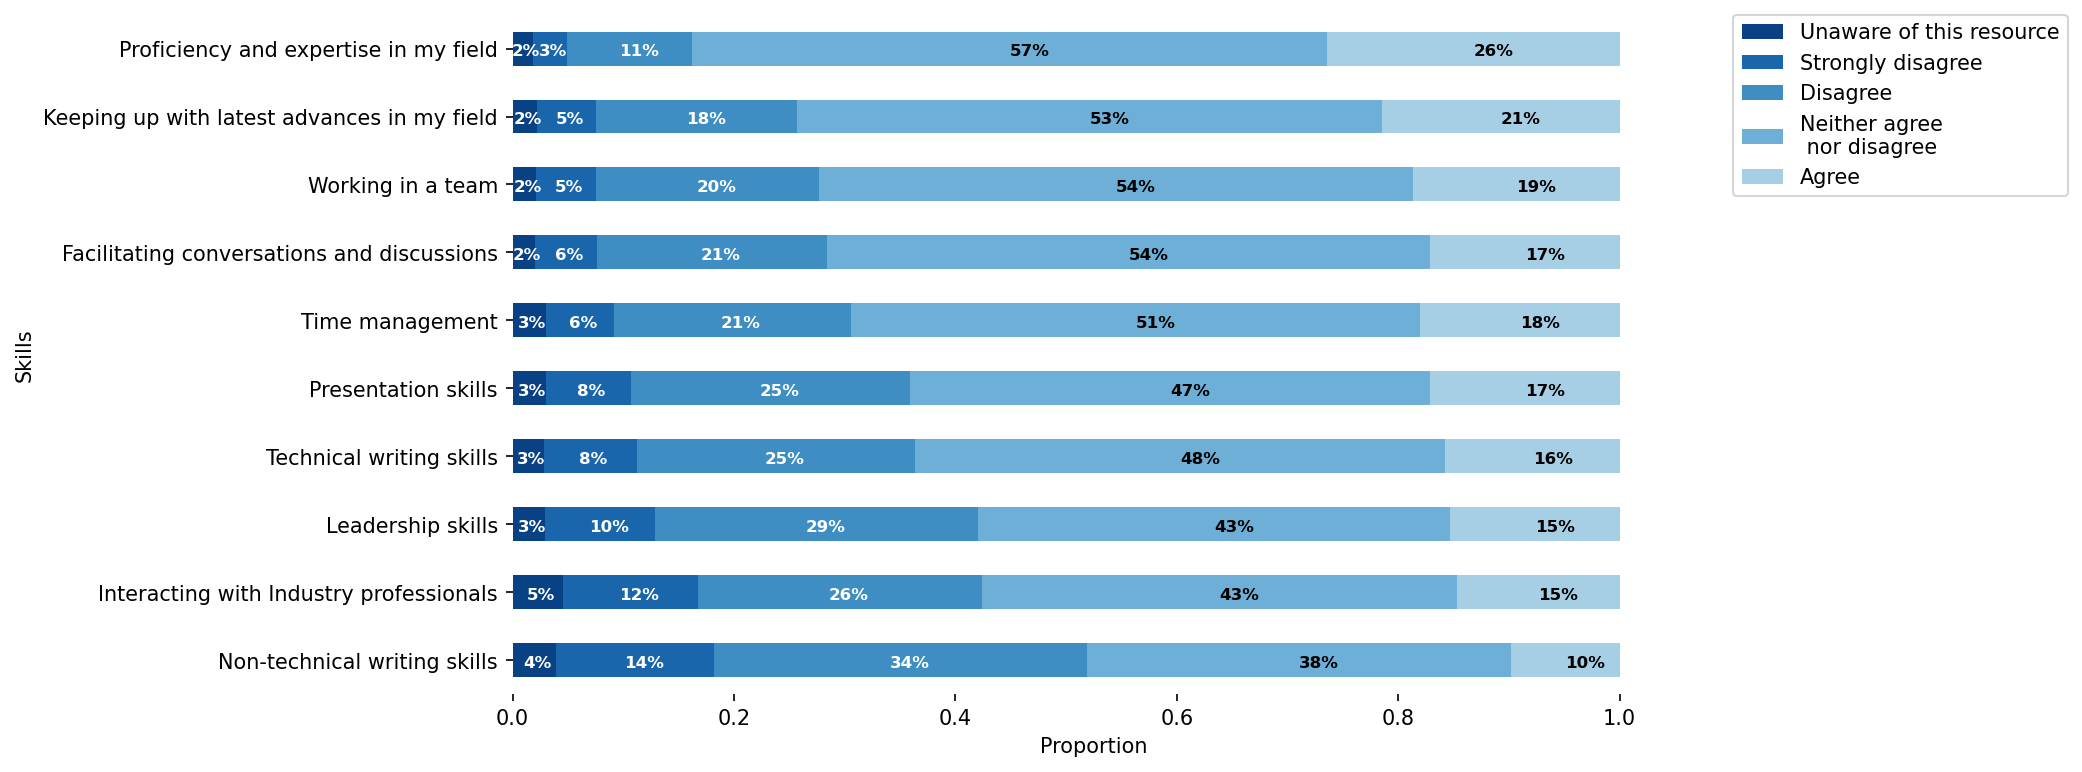

In [730]:
skill_count=skill.apply(pd.value_counts,axis=0)
b_prob=(skill_count[(skill_count.iloc[3:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(skill_count[(skill_count.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Skills")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [756]:
PDL_com=query_data(Q,qq,cleaned_data,"PDL",indx=4).dropna()
PDL_com.to_csv("output/pdl_com.csv")

Please share comments regarding the PDL Program.


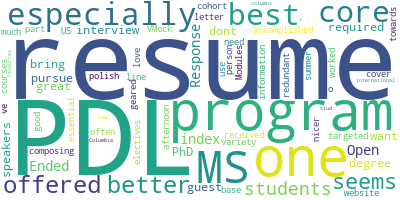

In [755]:
(PDL_com).reset_index(inplace=True)
long_string = (str((PDL_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('','')
long_string = long_string.replace('','')
long_string = long_string.replace('','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

In [671]:
(df3_2_library.mean()).sort_values().plot(kind="barh")
plt.ylabel("Resources")
plt.xlabel("importance")
plt.title("Significance of resources provided by CCE",fontsize=20)


for n,x in enumerate([*(df3_2_library.mean()).sort_values().index.values]):
        plt.text(x=0.5,
                 y=n - 0.11,
                 s=f'{df3_2_library.mean().loc[x] :0.5f}', 
                 color="white",
                 fontsize=12,
                 fontweight="bold")
        
(df3_2_library.mean()).sort_values(ascending=False)

NameError: name 'df3_2_library' is not defined

## Resources

In [546]:
resources_sat.mean(axis=0)
resources_sat_count=resources_sat.apply(pd.value_counts,axis=0)
b_prob

Ombuds Office  Center for Teaching and Learning (CTL)  \
0       0.487018                                0.409127   
1       0.009441                                0.016522   
2       0.020456                                0.026751   
3       0.259638                                0.254131   
4       0.126672                                0.190401   
5       0.096774                                0.103068   

   Counseling Psychological Services (CPS) Walk-In hours  \
0                                               0.282455   
1                                               0.021243   
2                                               0.040126   
3                                               0.305271   
4                                               0.206137   
5                                               0.144768   

   Graduate Career Placement (GCP) Team  Departmental advisor  \
0                              0.178600              0.109363   
1                              0.064516              0.059795   
2                              0.097561              0.099135   
3                              0.232101              0.213218   
4                              0.283242              0.314713   
5                              0.143981              0.203777   

   International Students and Scholars Office (ISSO)  \
0                                           0.169158   
1                                           0.014949   
2                                           0.023603   
3                                           0.214005   
4                                           0.343037   
5                                           0.235248   

   Department administration  Office of Graduate Student Affairs  \
0                   0.084186                            0.104642   
1                   0.050354                            0.022817   
2                   0.067663                            0.044847   
3                   0.223446                            0.243116   
4                   0.380016                            0.389457   
5                   0.194335                            0.195122   

   Professional Development and Leadership (PDL) Program  
0                                               0.033045  
1                                               0.029111  
2                                               0.068450  
3                                               0.192762  
4                                               0.416994  
5                                               0.259638

In [557]:
resources_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=6)
resources_sat.replace('Unaware of this resource',0,inplace=True)
resources_sat['degree']=degree

I am satisfied with the following resources with respect to guidance in my degree program.


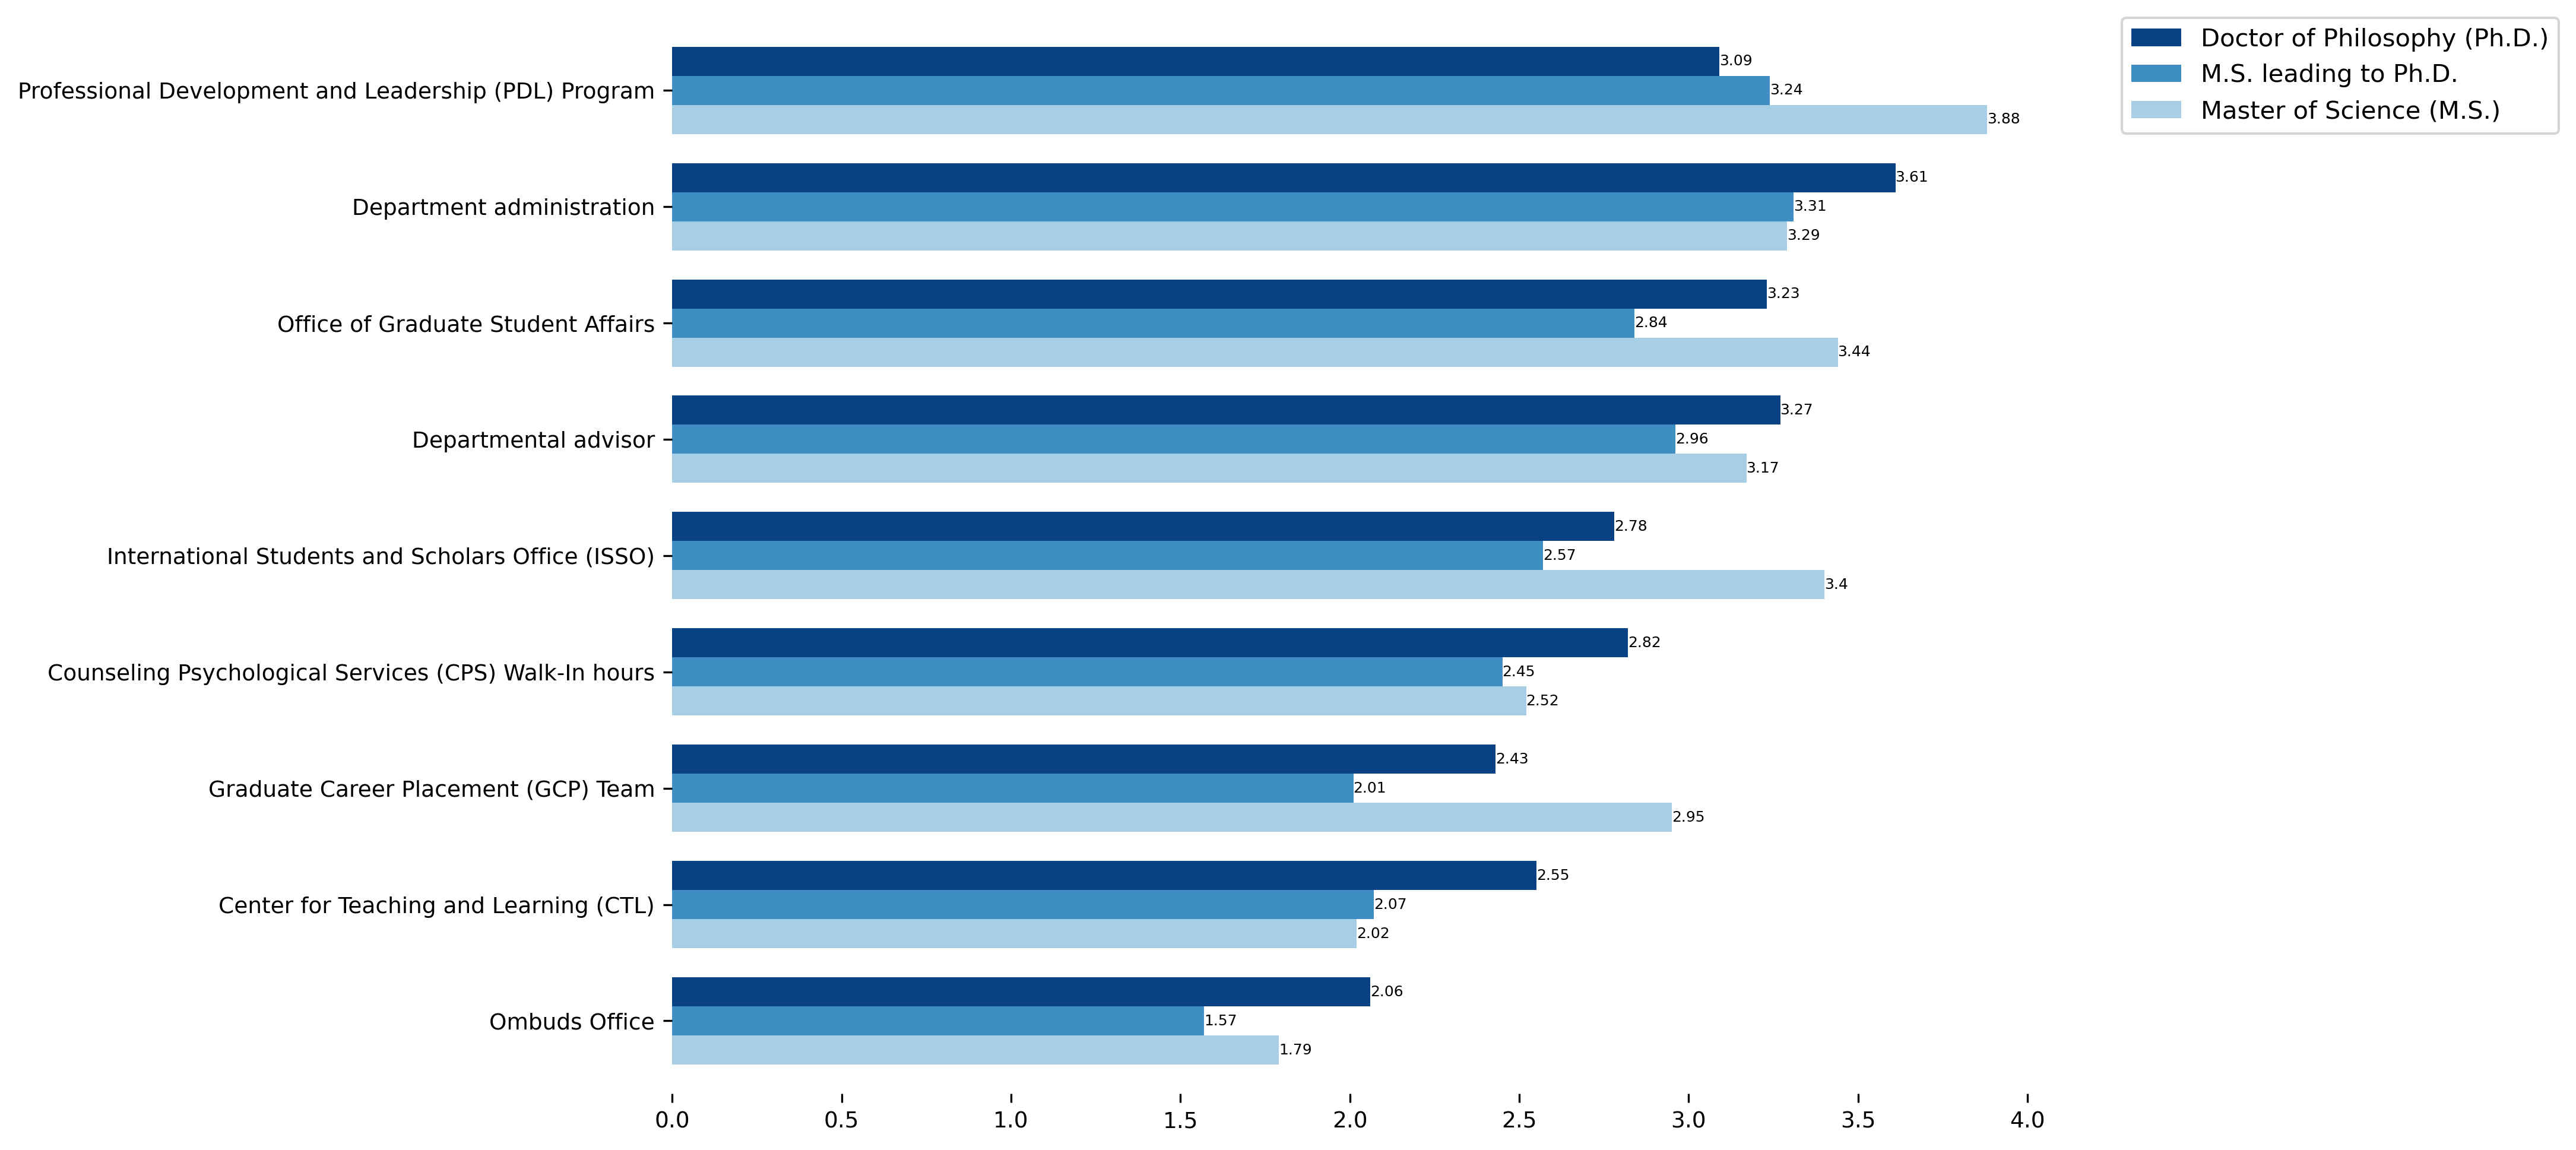

In [573]:

fig,ax=plt.subplots(figsize=(10,8),dpi=300)
aca_import['degree']=degree
df=resources_sat.groupby(['degree']).mean().round(2).drop(index='Professional Degree')
df=df[df.mean().sort_values().index[::-1]]
#indd=['Supplementary \n educational tools', 'Degree \n requirements',
 #      'Course Delivery \n Method', 'Instruction', 'Course content']
ax=df.T.plot.barh(ax=ax,colormap=cmap,width=0.75, rot=0 ,fontsize=9)
#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=6)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

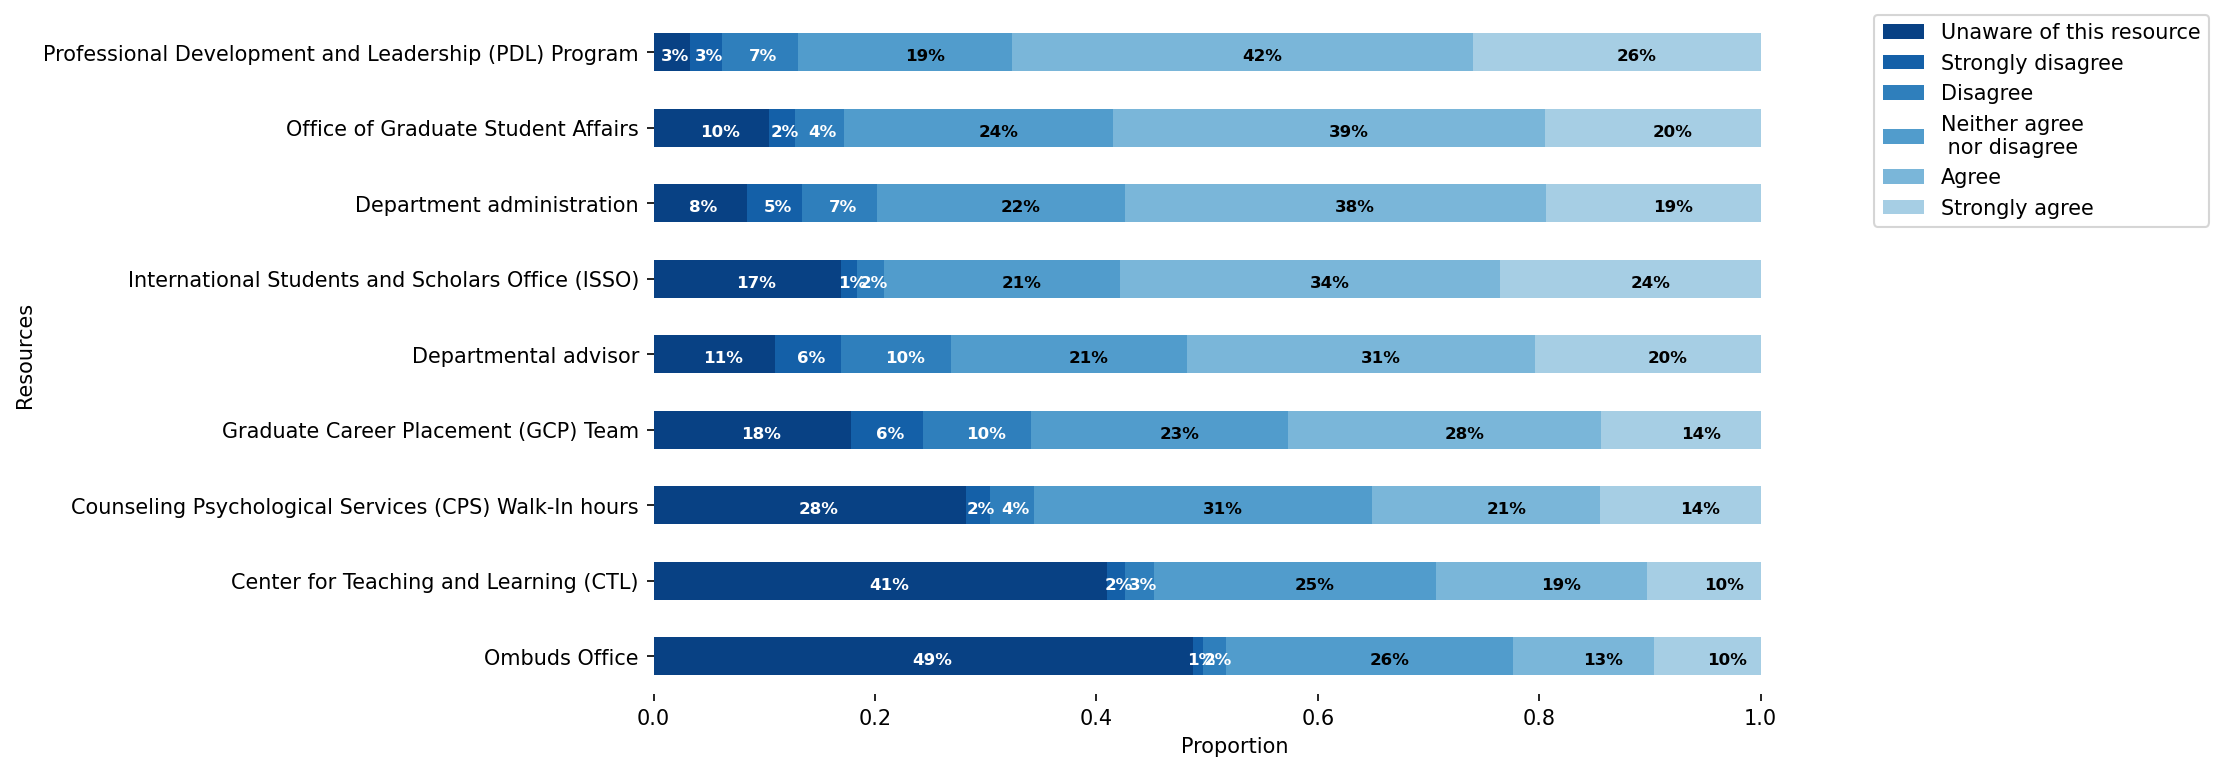

In [729]:

b_prob=(resources_sat_count[(resources_sat_count.iloc[3:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(resources_sat_count[(resources_sat_count.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

<BarContainer object of 9 artists>

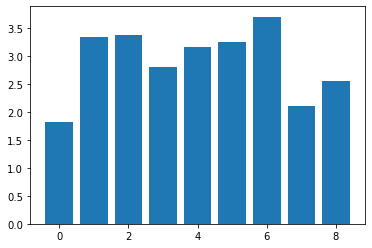

In [321]:
plt.bar(np.arange(len(resources_sat.mean(axis=0))),height=resources_sat.mean(axis=0))

## Canvas

In [665]:
canvas_sat=query_data(Q,qq,cleaned_data,"Canvas",indx=1)
canvas_sat.replace('Unaware of this Feature',0,inplace=True)
canvas_sat

I find the following features of Canvas convenient.


Assignment submissions Course announcements Access to course material  \
0                         4                    4                         4   
2                         5                    5                         5   
5                         5                    5                         5   
6                         4                    4                         4   
7                         4                    5                         5   
...                     ...                  ...                       ...   
1585                      5                    5                         5   
1586                      5                    5                         5   
1587                      5                    5                         5   
1588                      5                    5                         5   
1590                      5                    5                         5   

     Chat Ed discussion Collaborations Mobile access (Canvas app)  \
0       3             0              4                          4   
2       5             5              5                          5   
5       2             4              2                          5   
6       3             4              3                          4   
7       4             5              3                          0   
...   ...           ...            ...                        ...   
1585    4             5              4                          4   
1586    5             5              5                          5   
1587    0             1              1                          5   
1588    5             5              5                          5   
1590    4             4              4                          4   

     Video Library  
0                5  
2                5  
5                5  
6                4  
7                5  
...            ...  
1585             5  
1586             5  
1587             4  
1588             5  
1590             5  

[1271 rows x 8 columns]

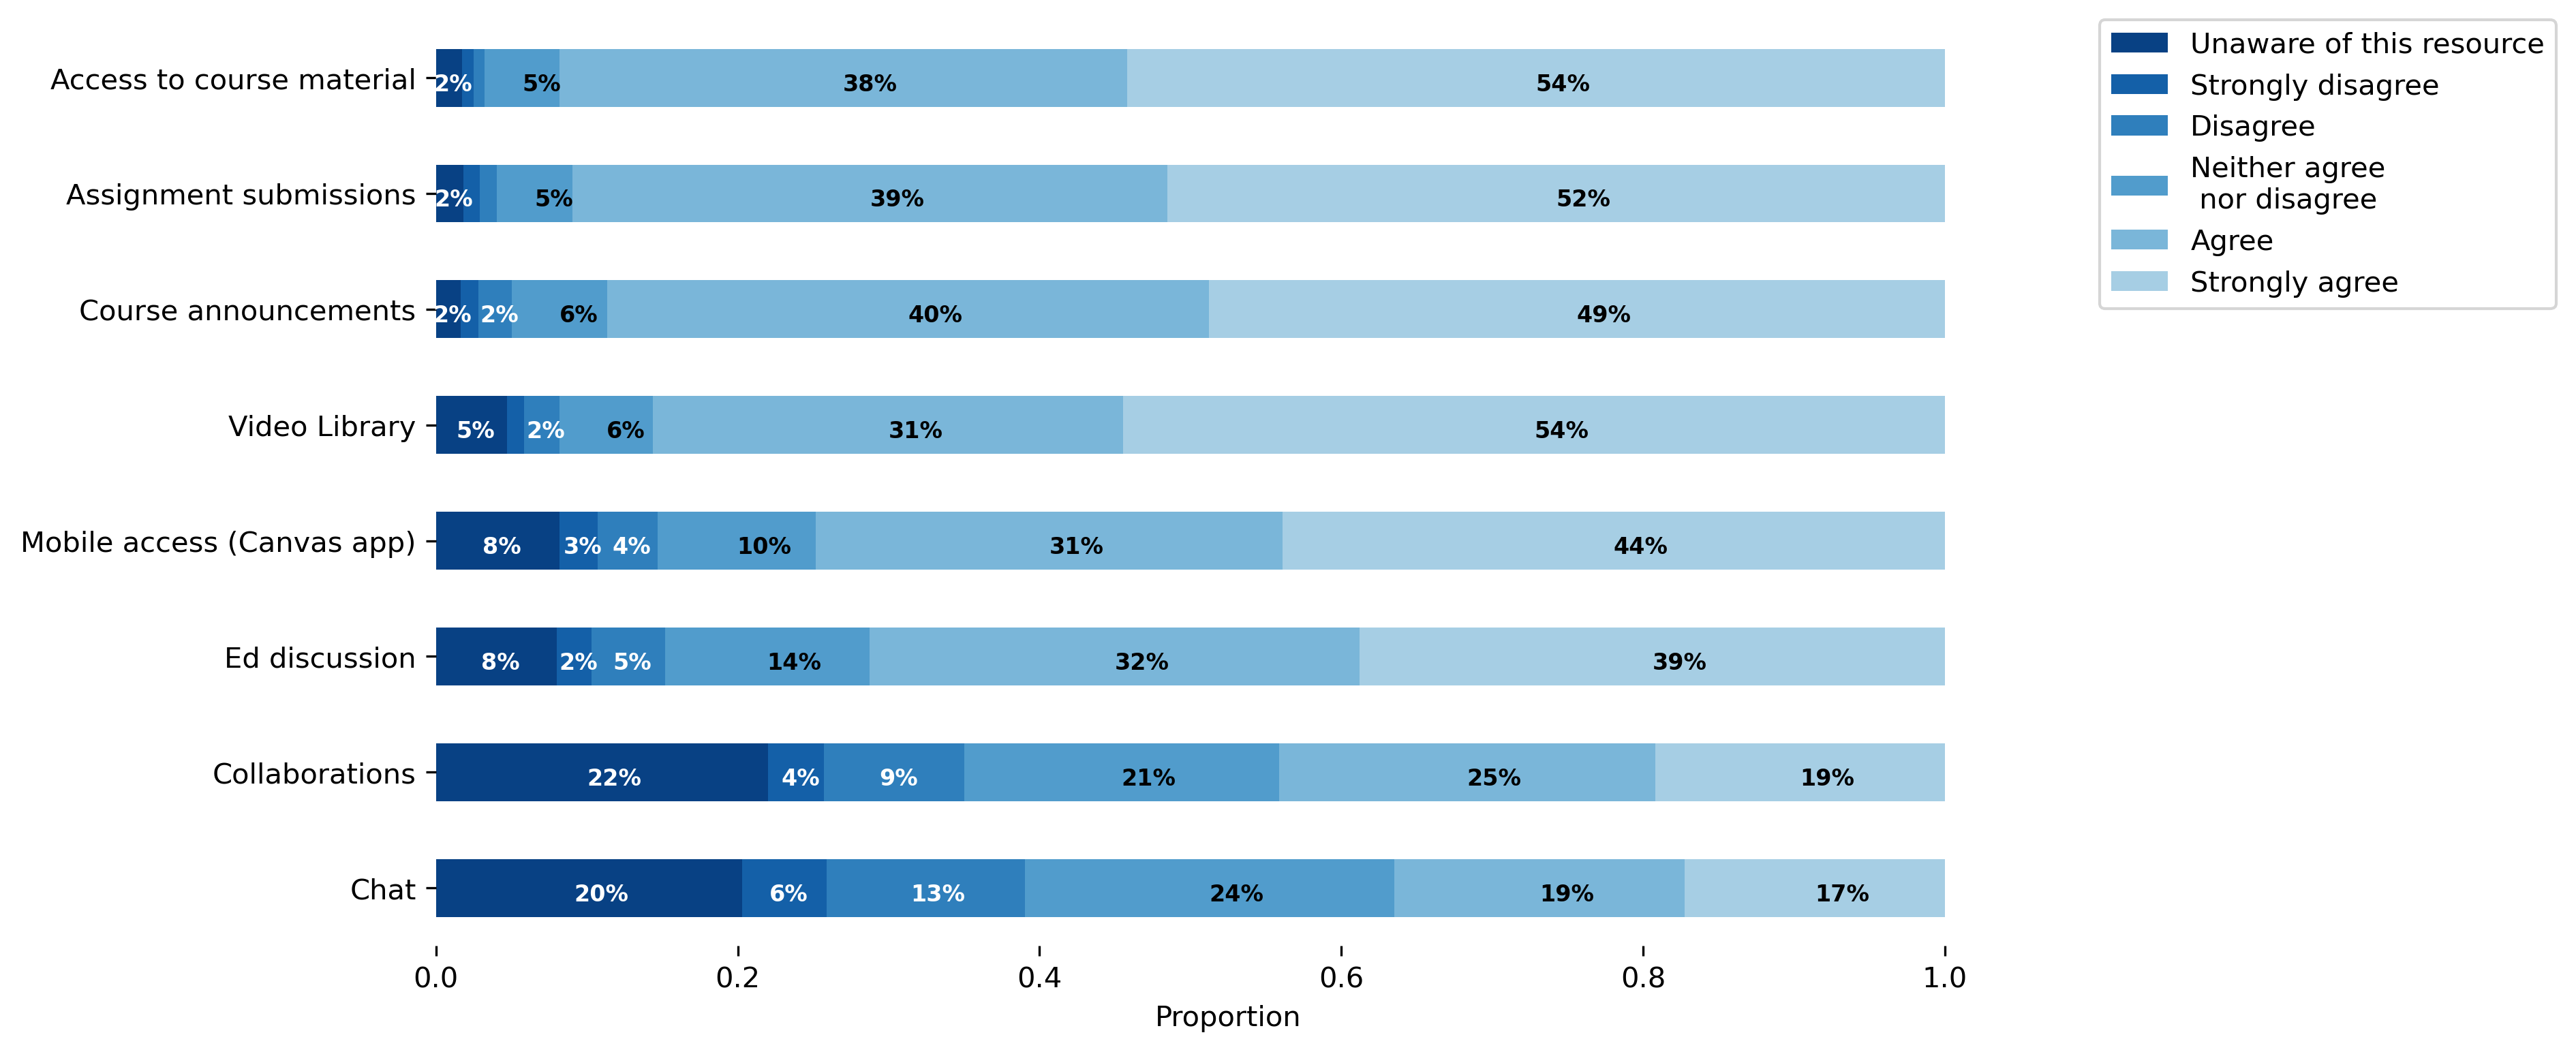

In [727]:
canvas_sat_count=canvas_sat.apply(pd.value_counts,axis=0)
b_prob=(canvas_sat_count[(canvas_sat_count.iloc[3:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(canvas_sat_count[(canvas_sat_count.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [666]:
canvas_com=query_data(Q,qq,cleaned_data,"Canvas",indx=2).dropna()
(canvas_com).reset_index(inplace=True)
canvas_com
#.to_csv("output/canvas_comments.csv")

Please enter any additional comments regarding Canvas:


index  \
0        6   
1       17   
2       26   
3       43   
4       45   
..     ...   
108   1511   
109   1517   
110   1528   
111   1532   
112   1549   

                                                                                                         Open-Ended Response  
0                                                     Email notifications are usually a bit late but overall it's still good  
1                                                                       please provide a way to contact people from my class  
2    2 out of 8 of my classes used any collaboration with students, TAs, and Professors in forum format (e.g., ask a ques...  
3    On my phone, I always get the same annoucement 2 times on canvas and one time from email. And when prof adding annot...  
4                                                                                                       The inbox is great.   
..                                                                                                                       ...  
108                                                            Canvas keeps sending repeated notifications which is annoying  
109                                                                                                      i do not have any.   
110  Canvas, while on hand is really intuitive, has its way of portraying legacy technology based applications which migh...  
111  I don't use Chat at all.  I don't like Ed as much as I liked Piazza.  The assignment and video library are good feat...  
112                                                                                 its not great but really doesn't matter   

[113 rows x 2 columns]

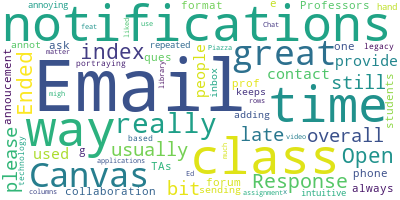

In [648]:
from wordcloud import WordCloud
long_string = (str((canvas_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('canvas','')
long_string = long_string.replace('good','')
#long_string = long_string.replace('one','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

## SSOL

In [649]:
ssol_sat=query_data(Q,qq,cleaned_data,"SSOL",indx=1)
ssol_sat.replace('Unaware of this Feature',0,inplace=True)

I find the following features of SSOL convenient.


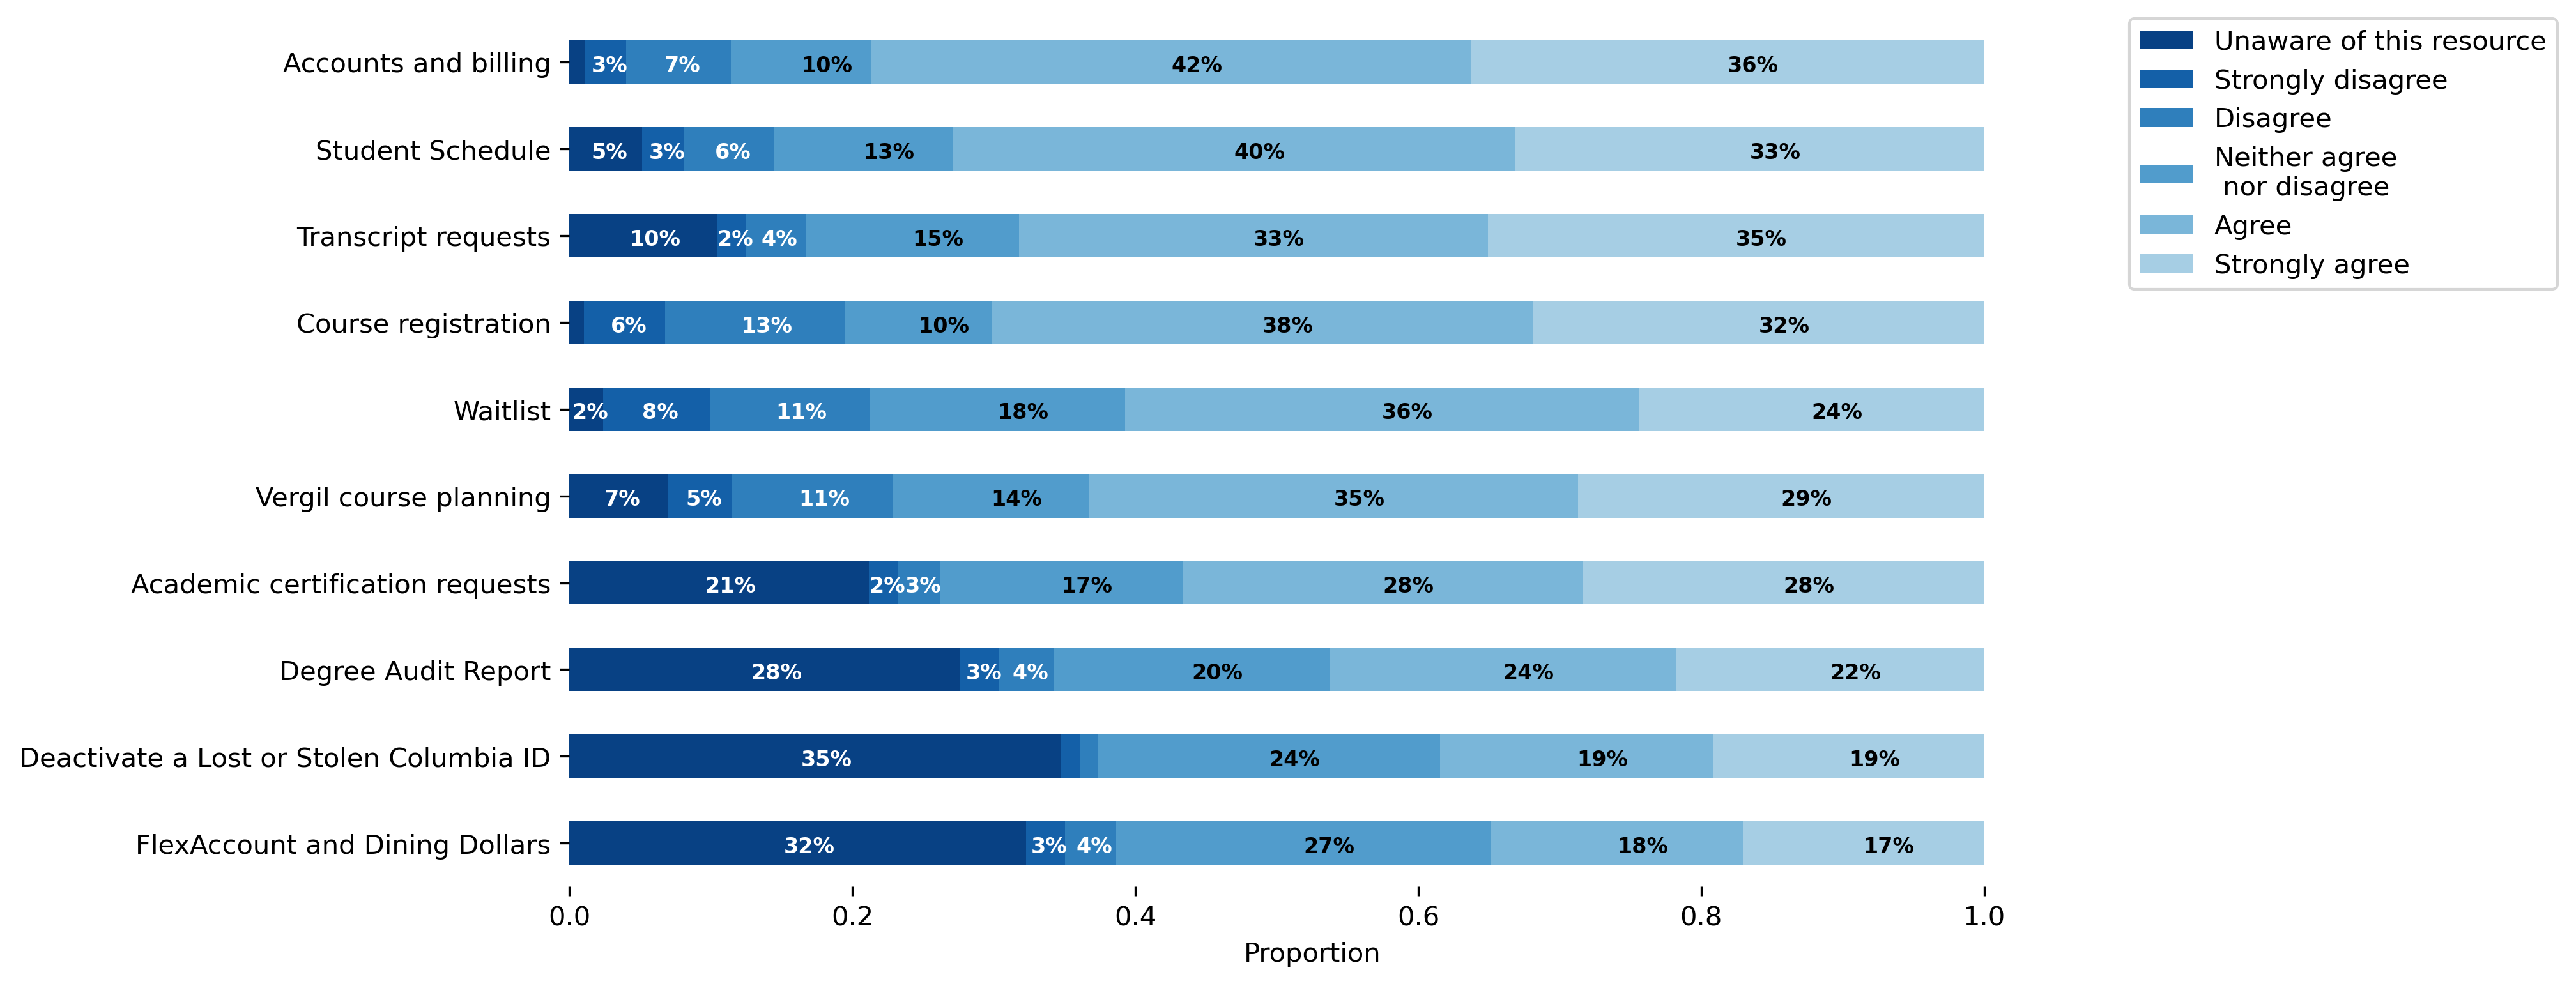

In [726]:
ssol_sat_count=ssol_sat.apply(pd.value_counts,axis=0)
b_prob=(ssol_sat_count[(ssol_sat_count.iloc[3:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(ssol_sat_count[(ssol_sat_count.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [654]:
ssol_com=query_data(Q,qq,cleaned_data,"SSOL",indx=2).dropna()
(ssol_com).reset_index(inplace=True)
ssol_com
#.to_csv("output/ssol_comments.csv")

Please enter any additional feedback you might have regarding SSOL:


index  \
0        6   
1       17   
2       26   
3       39   
4       43   
..     ...   
160   1510   
161   1517   
162   1533   
163   1540   
164   1549   

                                                                                                       Open-Ended Response.1  
0                                                                  It would be nice to not have strict registration windows.  
1    why are there two websites? remove virgil and just make SSOL the only website tat has to do with finding classes for...  
2    Neither agree nor disagree is I have not used it.  Course registration the first time around was confusing.  Maybe I...  
3                                                            Cannot submit the graduation application form directly on SSOL.  
4    The time to get paper edition transcript takes too long, and for international students, if we will go back to our h...  
..                                                                                                                       ...  
160  Columbia really needs to modernize Vergil/Course Catalog/SSOL. Current UI is terrible. Also, we need to have one pla...  
161                                                 SSOL must be redesigned. A total disaster of a website. Smells like 90s.  
162                                                   Really needs an update: no reason for there to be registration periods  
163                                                                  Canvas' schedule more useful and accessible than SSOL's  
164  it's a bargain bin solution, and it shows. (doesn't the universty have money for things other than the lawn?)   the ...  

[165 rows x 2 columns]

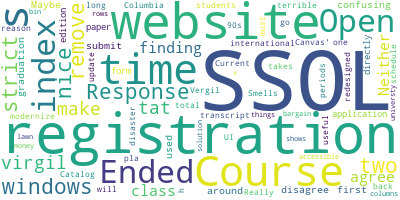

In [664]:
long_string = (str((ssol_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('','')
long_string = long_string.replace('really','')
long_string = long_string.replace('need','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

In [655]:

import sklearn.feature_extraction.text as sk_text
Tfidf_vectorizer = sk_text.TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1), min_df = .05 , max_df = .85)

matrix = Tfidf_vectorizer.fit_transform(ssol_com['Open-Ended Response.1'])


In [660]:
from sklearn.decomposition import LatentDirichletAllocation


lda=LatentDirichletAllocation(n_components=20,n_jobs=-1,
                             random_state=123)


X_lda=lda.fit_transform(matrix)
  

In [661]:
vocab=Tfidf_vectorizer.get_feature_names()

vocab=np.array(vocab)

for topic_idx in range(20):
    a=vocab[np.argsort(lda.components_[topic_idx])[::-1][:5]]
    b=' '.join(a)
    print(f'Topic #{topic_idx:2d} : {b}')
 

Topic # 0 : vergil course use registration know
Topic # 1 : registration students day time course
Topic # 2 : transcript know students time doesn
Topic # 3 : waitlist know like course students
Topic # 4 : registration students course like ssol
Topic # 5 : classes ssol vergil course like
Topic # 6 : time registration students course classes
Topic # 7 : doesn waitlist ssol registration know
Topic # 8 : day registration time students like
Topic # 9 : registration students course like ssol
Topic #10 : need use registration course billing
Topic #11 : user interface like use ssol
Topic #12 : registration students course like ssol
Topic #13 : ssol like use waitlist course
Topic #14 : day like use waitlist course
Topic #15 : better use waitlist registration vergil
Topic #16 : registration students course like ssol
Topic #17 : courses course waitlist day registration
Topic #18 : billing students know day registration
Topic #19 : course registration like students ssol


## Library

In [ ]:
How many times per week do you frequent the following libraries?

In [687]:
lib_fre=query_data(Q,qq,cleaned_data,"libraries",indx=1)
lib_fre.replace("2-Jan","1-2",inplace=True)
lib_fre.replace("3-Feb",'2-3',inplace=True)
lib_fre.replace("4-Mar","3-4",inplace=True)

How many times per week do you frequent the following libraries?


The following resources at Science and Engineering Library are useful to me:


Individual study and/or work space Group study and/or work space  \
0                                     4                             3   
2                                     4                             4   
5                                     3                             3   
6                                     3                             3   
7                                     3                             5   
...                                 ...                           ...   
1585                                  4                             4   
1586                                  5                             5   
1587                                  5                             5   
1588                                  4                             4   
1590                                  4                             4   

     Reference materials Computer terminal Printing and scanning facilities  \
0                      4                 4                                4   
2                      4                 4                                4   
5                      3                 3                                3   
6                      3                 3                                3   
7                      3                 5                                3   
...                  ...               ...                              ...   
1585                   3                 3                                3   
1586                   5                 5                                5   
1587                   1                 1                                1   
1588                   3                 4                                4   
1590                   4                 4                                4   

     Hours of operation  
0                     4  
2                     4  
5                     3  
6                     3  
7                     3  
...                 ...  
1585                  4  
1586                  5  
1587                  5  
1588                  3  
1590                  4  

[1271 rows x 6 columns]

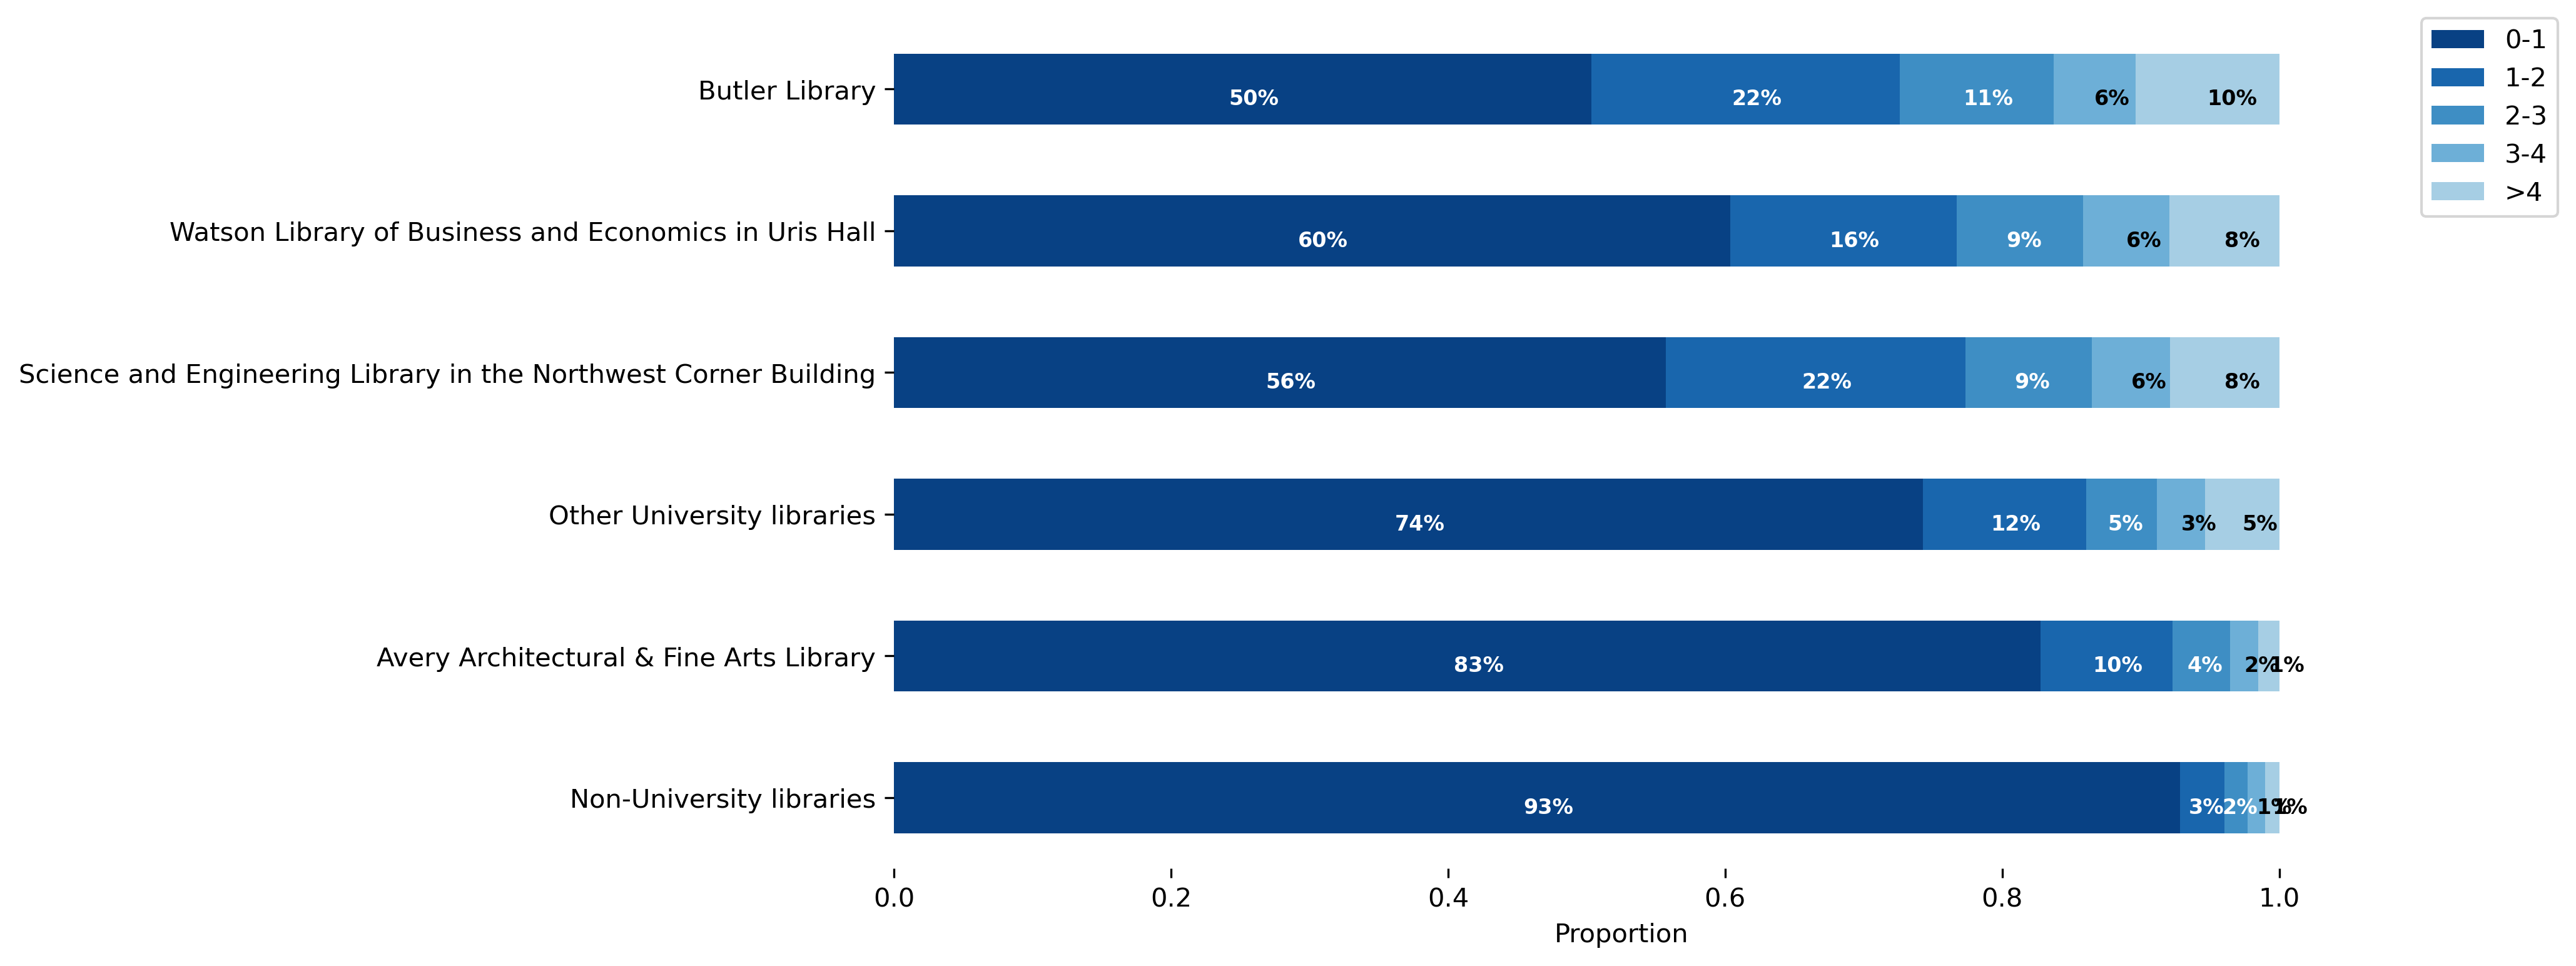

In [722]:
lib_fre_count=lib_fre.apply(pd.value_counts,axis=0)
b_prob=(lib_fre_count[(lib_fre_count.iloc[3:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(lib_fre_count[(lib_fre_count.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}',
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## SEL

In [709]:
sel=query_data(Q,qq,cleaned_data,"Engineering Library",indx=1)

The following resources at Science and Engineering Library are useful to me:


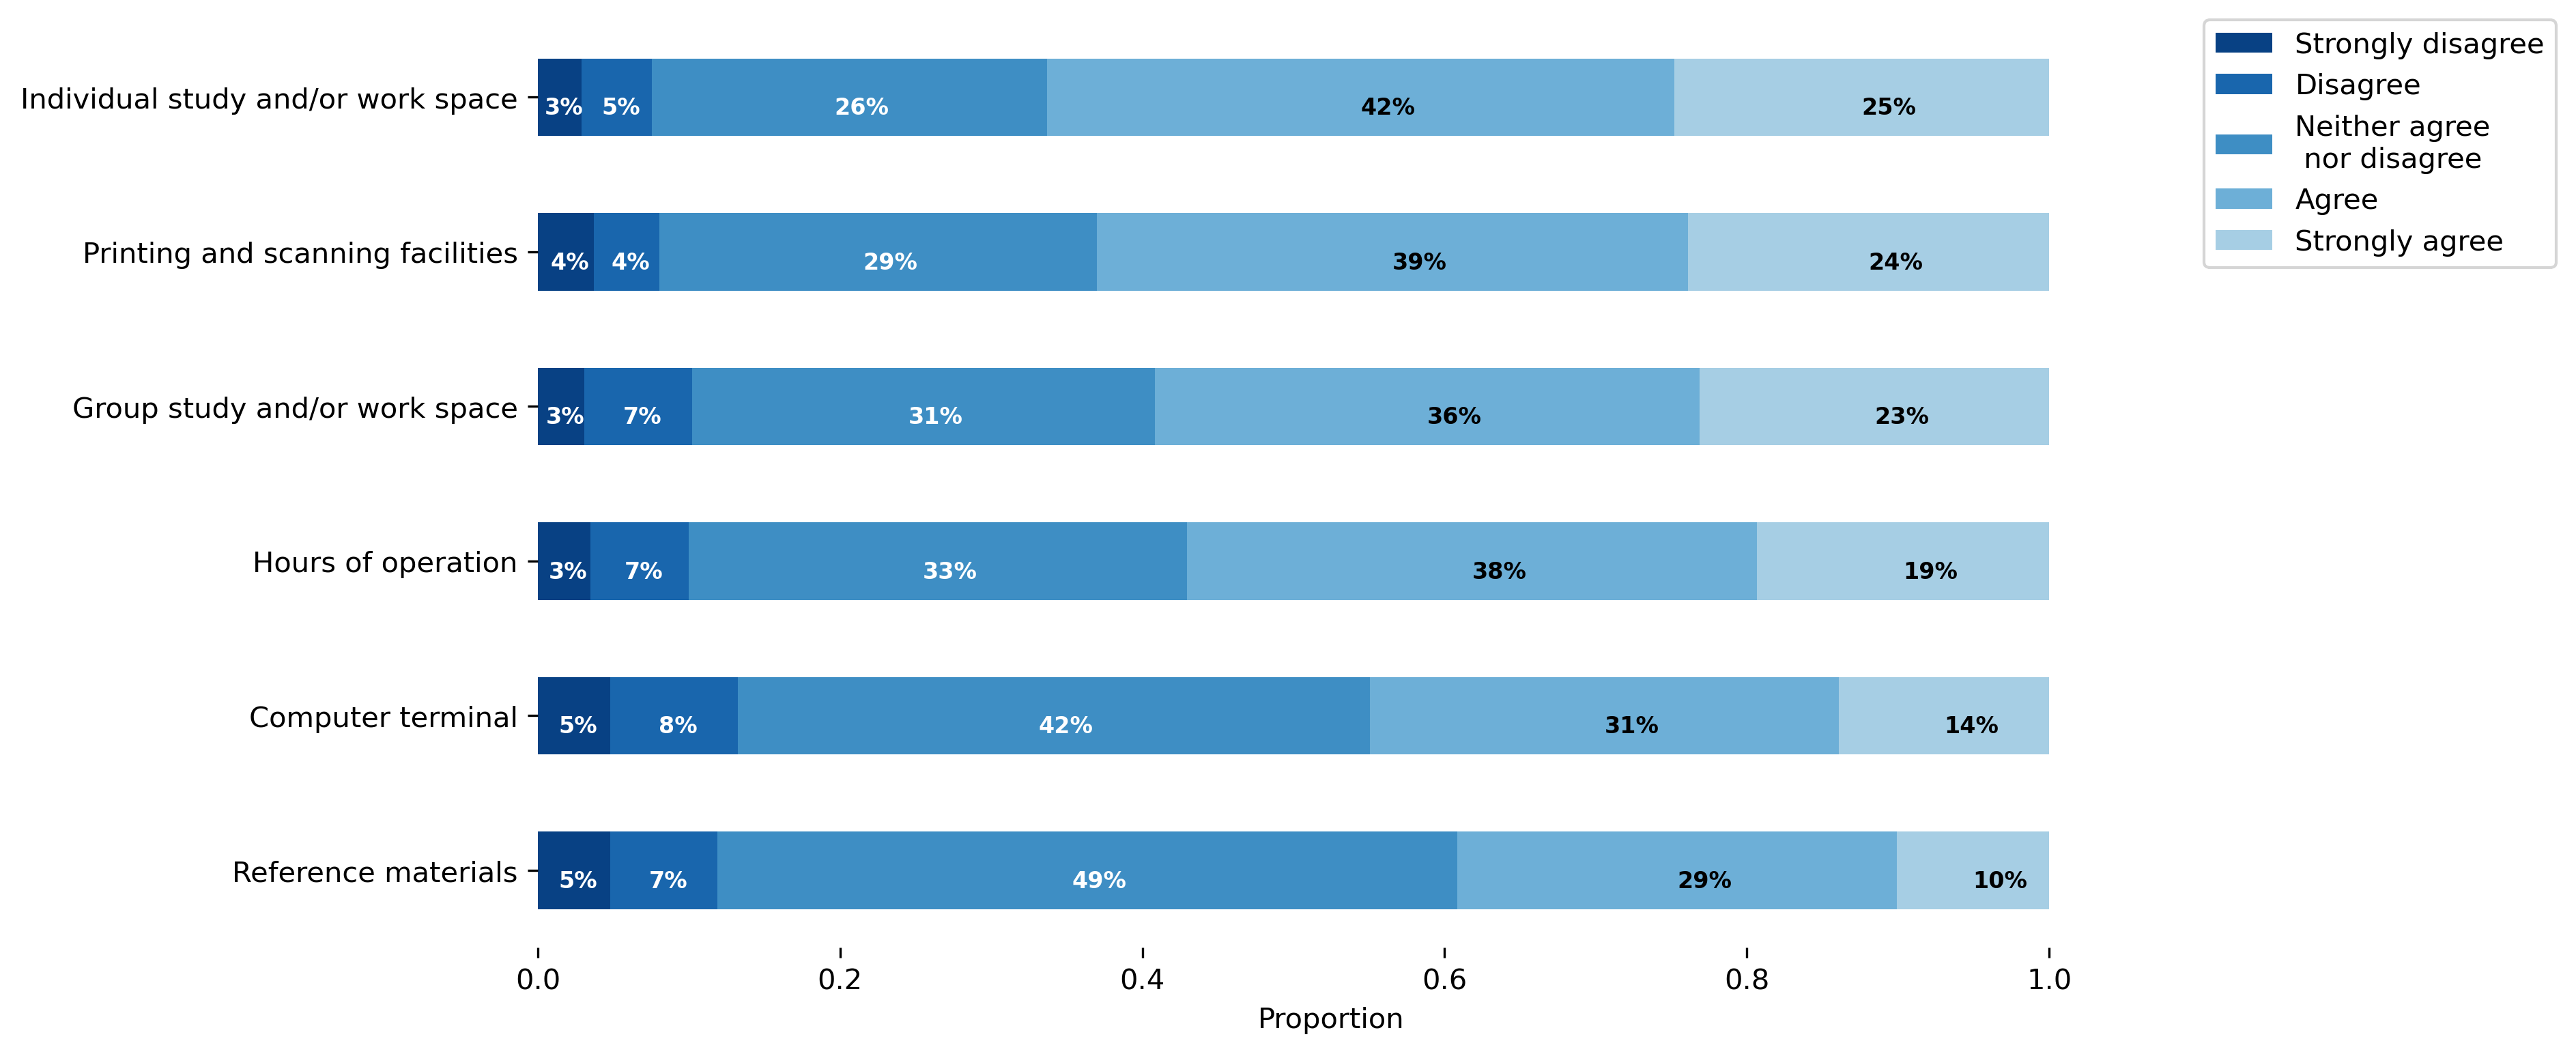

In [725]:
sel_count=sel.apply(pd.value_counts,axis=0)
b_prob=(sel_count[(sel_count.iloc[3:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(sel_count[(sel_count.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## Facility

In [749]:
inddf=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Not Applicable']

University Gym  \
0             190   
1             169   
2             177   
3             229   
4             293   
5             213   

   Availability of transportation to the CUIMC campus on the weekends  \
0                                                                 396   
1                                                                  49   
2                                                                  64   
3                                                                 311   
4                                                                 251   
5                                                                 200   

   Columbia Makerspace  Computer Lab at the Engineering Terrace 251/252  \
0                  413                                              404   
1                   18                                               16   
2                   21                                               29   
3                  307                                              326   
4                  301                                              292   
5                  211                                              204   

   Availability of reservable student group space  \
0                                             165   
1                                              80   
2                                             160   
3                                             263   
4                                             379   
5                                             224   

   Quality and maintenance of equipment in labs  \
0                                           291   
1                                            18   
2                                            53   
3                                           260   
4                                           397   
5                                           252   

   Availability of group study space  \
0                                105   
1                                 77   
2                                179   
3                                242   
4                                420   
5                                248   

   Availability of advanced computing resources  \
0                                           251   
1                                            24   
2                                            70   
3                                           309   
4                                           370   
5                                           247   

   Availability of engineering specific software in libraries/computer labs  \
0                                                                       262   
1                                                                        19   
2                                                                        56   
3                                                                       313   
4                                                                       376   
5                                                                       245   

   Availability of engineering specific software that can be installed on your personal computer  \
0                                                                                            154   
1                                                                                             59   
2                                                                                            123   
3                                                                                            267   
4                                                                                            399   
5                                                                                            269   

   Department lounge  Carleton Commons  Elevators in Mudd building  \
0                157               212                          49   
1                 82                16               

I am satisfied with the following.


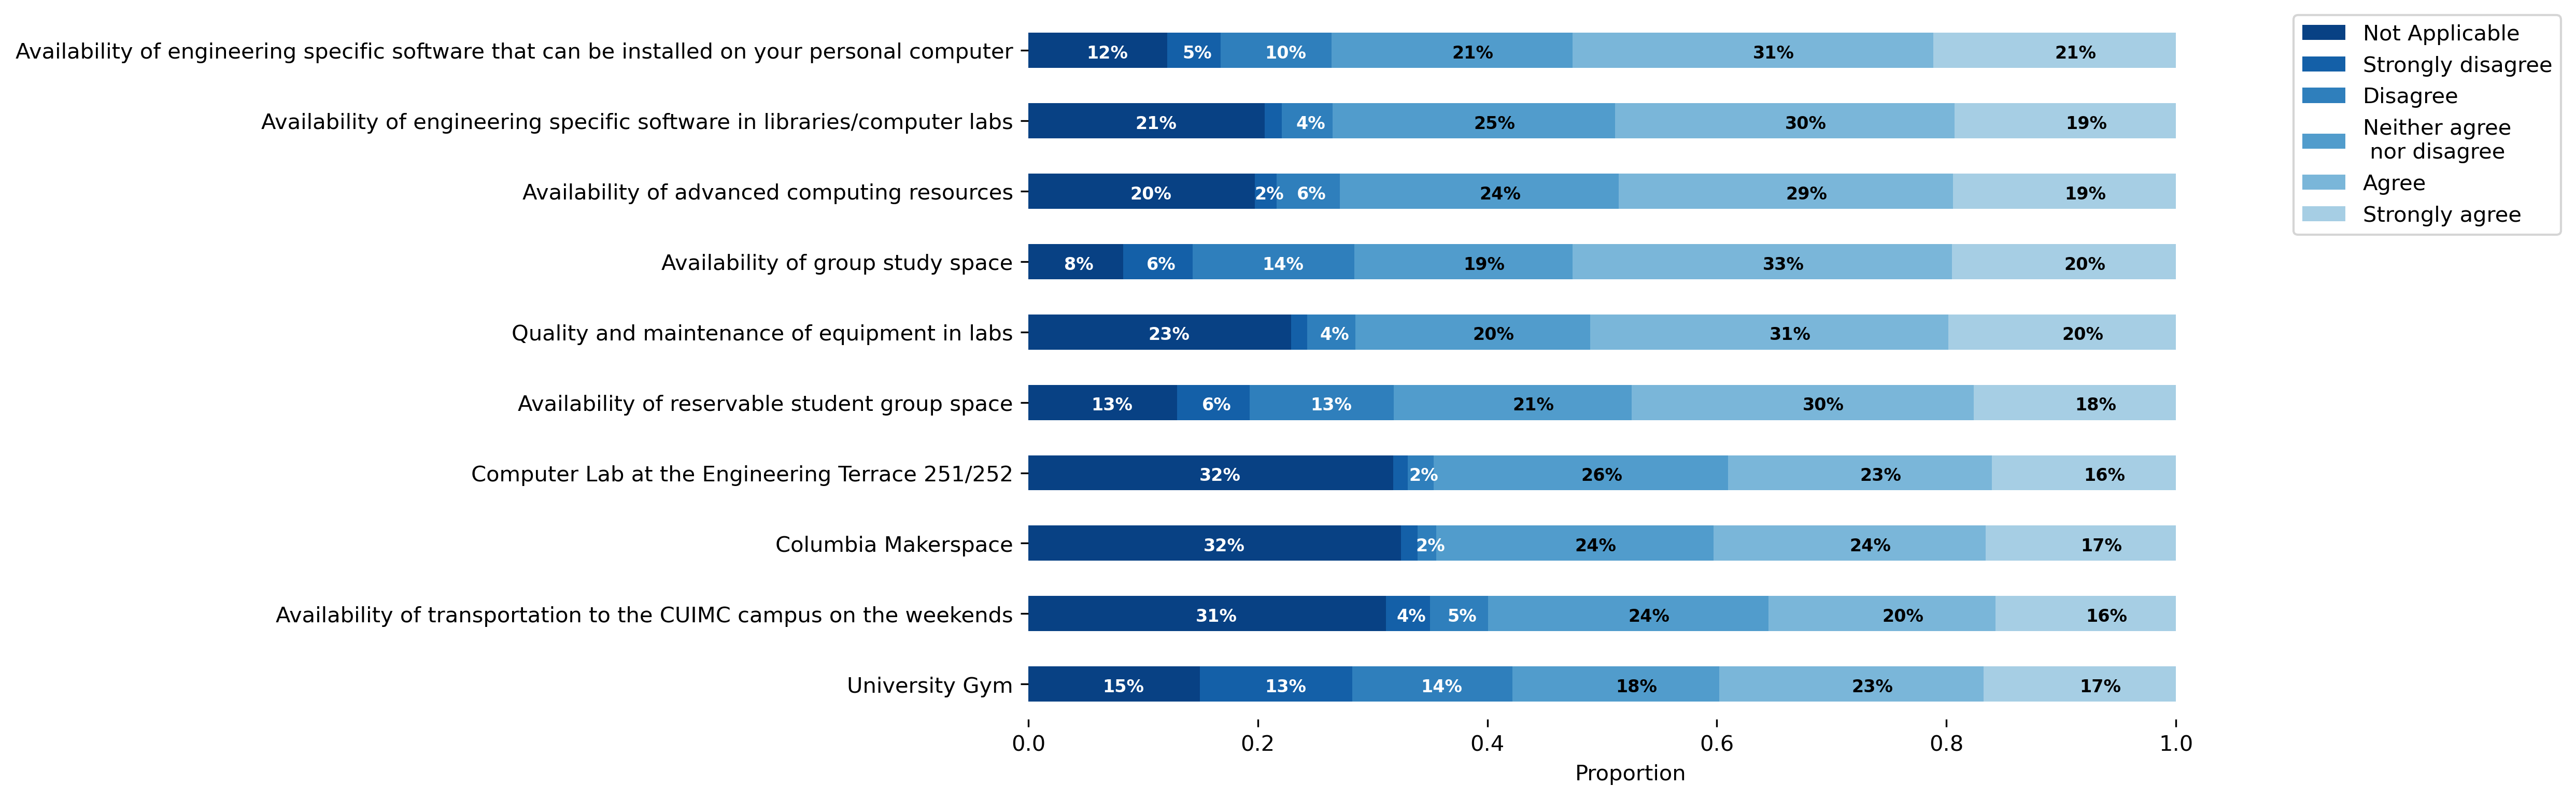

In [750]:
fac=query_data(Q,qq,cleaned_data,"I am satisfied with the following.",indx=3)
fac.replace("Not Applicable",0,inplace=True)
fac_count=fac.apply(pd.value_counts,axis=0)
fac0=fac_count[(fac_count.iloc[3:,:].sum()).sort_values().index]
fac1=fac0.iloc[:,:10]
b_prob=fac1.apply(lambda x: x / x.sum(), axis=0)
aaa=fac1.T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddf[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [745]:
fac2

Accessibility of Mudd on the weekends  \
2                                                  73   
3                                                 228   
4                                                 457   
5                                                 341   
Not Applicable                                    139   
1                                                  33   

                Availability of advanced computing resources  \
2                                                         70   
3                                                        309   
4                                                        370   
5                                                        247   
Not Applicable                                           251   
1                                                         24   

                Availability of engineering specific software in libraries/computer labs  \
2                                                                                     56   
3                                                                                    313   
4                                                                                    376   
5                                                                                    245   
Not Applicable                                                                       262   
1                                                                                     19   

                Cleanliness of laboratory and office space  \
2                                                       48   
3                                                      216   
4                                                      467   
5                                                      328   
Not Applicable                                         196   
1                                                       16   

                Quality and maintenance of equipment in labs  \
2                                                         53   
3                                                        260   
4                                                        397   
5                                                        252   
Not Applicable                                           291   
1                                                         18   

                Speed of wired internet in Mudd and CEPSR  University Gym  \
2                                                      23             177   
3                                                     220             229   
4                                                     458             293   
5                                                     321             213   
Not Applicable                                        240             190   
1                                                       9             169   

                Computer Lab at the Engineering Terrace 251/252  \
2                                                            29   
3                                                           326   
4                                                           292   
5                                                           204   
Not Applicable                                              404   
1                                                            16   

                Columbia Makerspace  \
2                                21   
3                               307   
4                               301   
5                               211   
Not Applicable                  413   
1                                18   

                Availability of transportation to the CUIMC campus on the weekends  
2                                                                               64  
3                                                                              311  
4                                                                              251  
5             

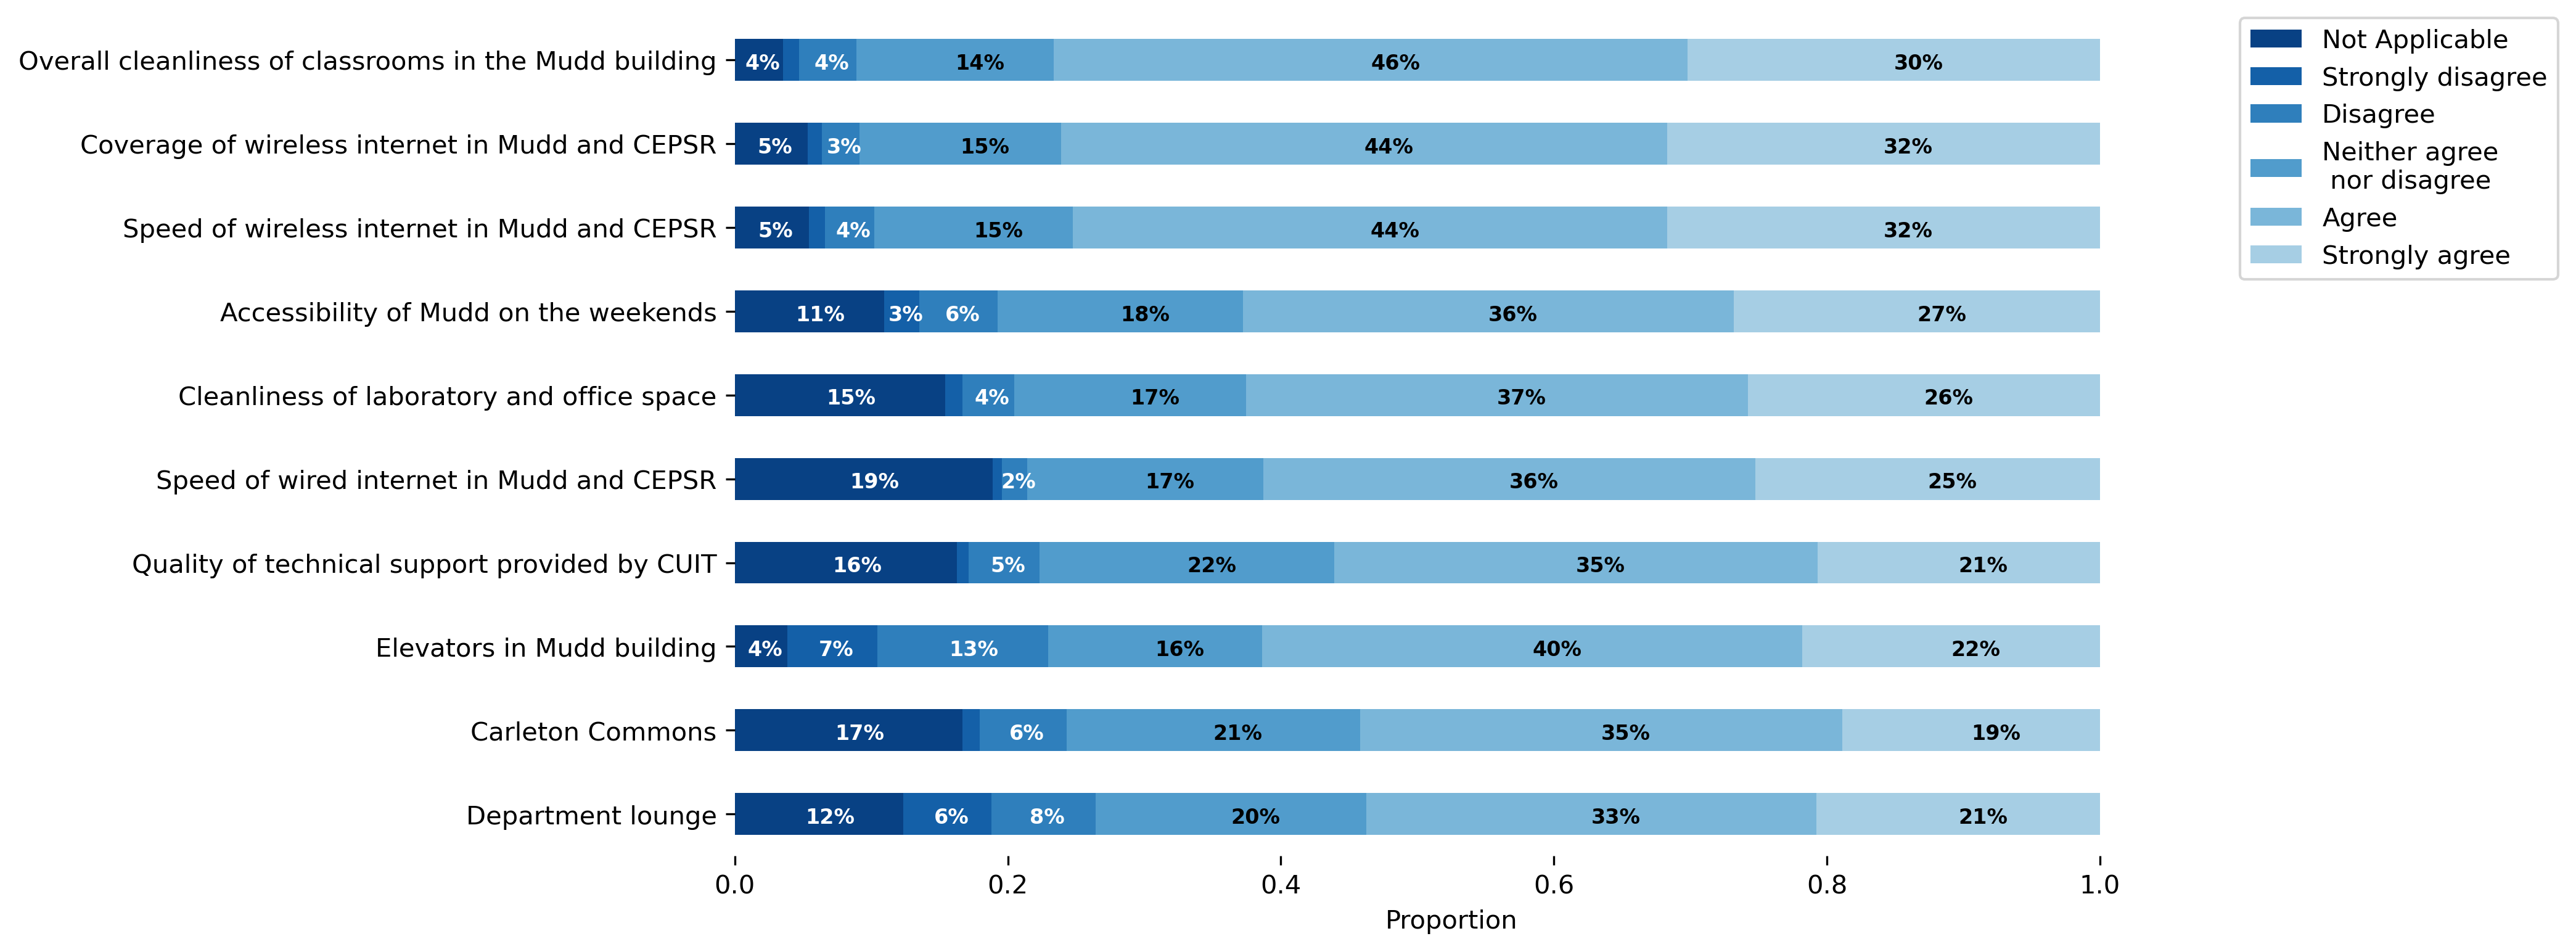

In [751]:

fac2=fac0.iloc[:,10:]
b_prob=fac2.apply(lambda x: x / x.sum(), axis=0)
aaa=fac2.T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddf[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## Career Development

In [ ]:
Are you currently looking for a job or plan to look for one in the near future?

In [758]:
lookingforjob=query_data(Q,qq,cleaned_data,"looking for a job",indx=1)
lookingforjob.value_counts()

Are you currently looking for a job or plan to look for one in the near future?


Response.10
Yes            928
No             264
Not Sure        79
dtype: int64

In [ ]:
The following resources have been/were useful in aiding my job search:

In [770]:
jobres=query_data(Q,qq,cleaned_data,"job search",indx=1)
jobres['looking']=lookingforjob
jobres

The following resources have been/were useful in aiding my job search:


Alumni networking events Personal contacts Faculty  \
0                           3                 3       4   
2                           4                 2       2   
5                           2                 4       4   
6                           3                 3       2   
7                           3                 3       2   
...                       ...               ...     ...   
1585                        3                 4       2   
1586                        5                 5       5   
1587                        2                 4       3   
1588                        3                 4       4   
1590                        1                 1       1   

     Department administration/Career placement officer  \
0                                                     4   
2                                                     4   
5                                                     4   
6                                                     3   
7                                                     4   
...                                                 ...   
1585                                                  3   
1586                                                  5   
1587                                                  1   
1588                                                  4   
1590                                                  1   

     EGSC career related events Department-sponsored career events  \
0                             4                                  4   
2                             3                                  2   
5                             2                                  2   
6                             3                                  3   
7                             2                                  2   
...                         ...                                ...   
1585                          3                                  3   
1586                          5                                  5   
1587                          4                                  1   
1588                          4                                  4   
1590                          1                                  1   

     Company Information Sessions  
0                               4  
2                               2  
5                               2  
6                               3  
7                               3  
...                           ...  
1585                            2  
1586                            5  
1587                            4  
1588                            3  
1590                            1  

[1271 rows x 7 columns]

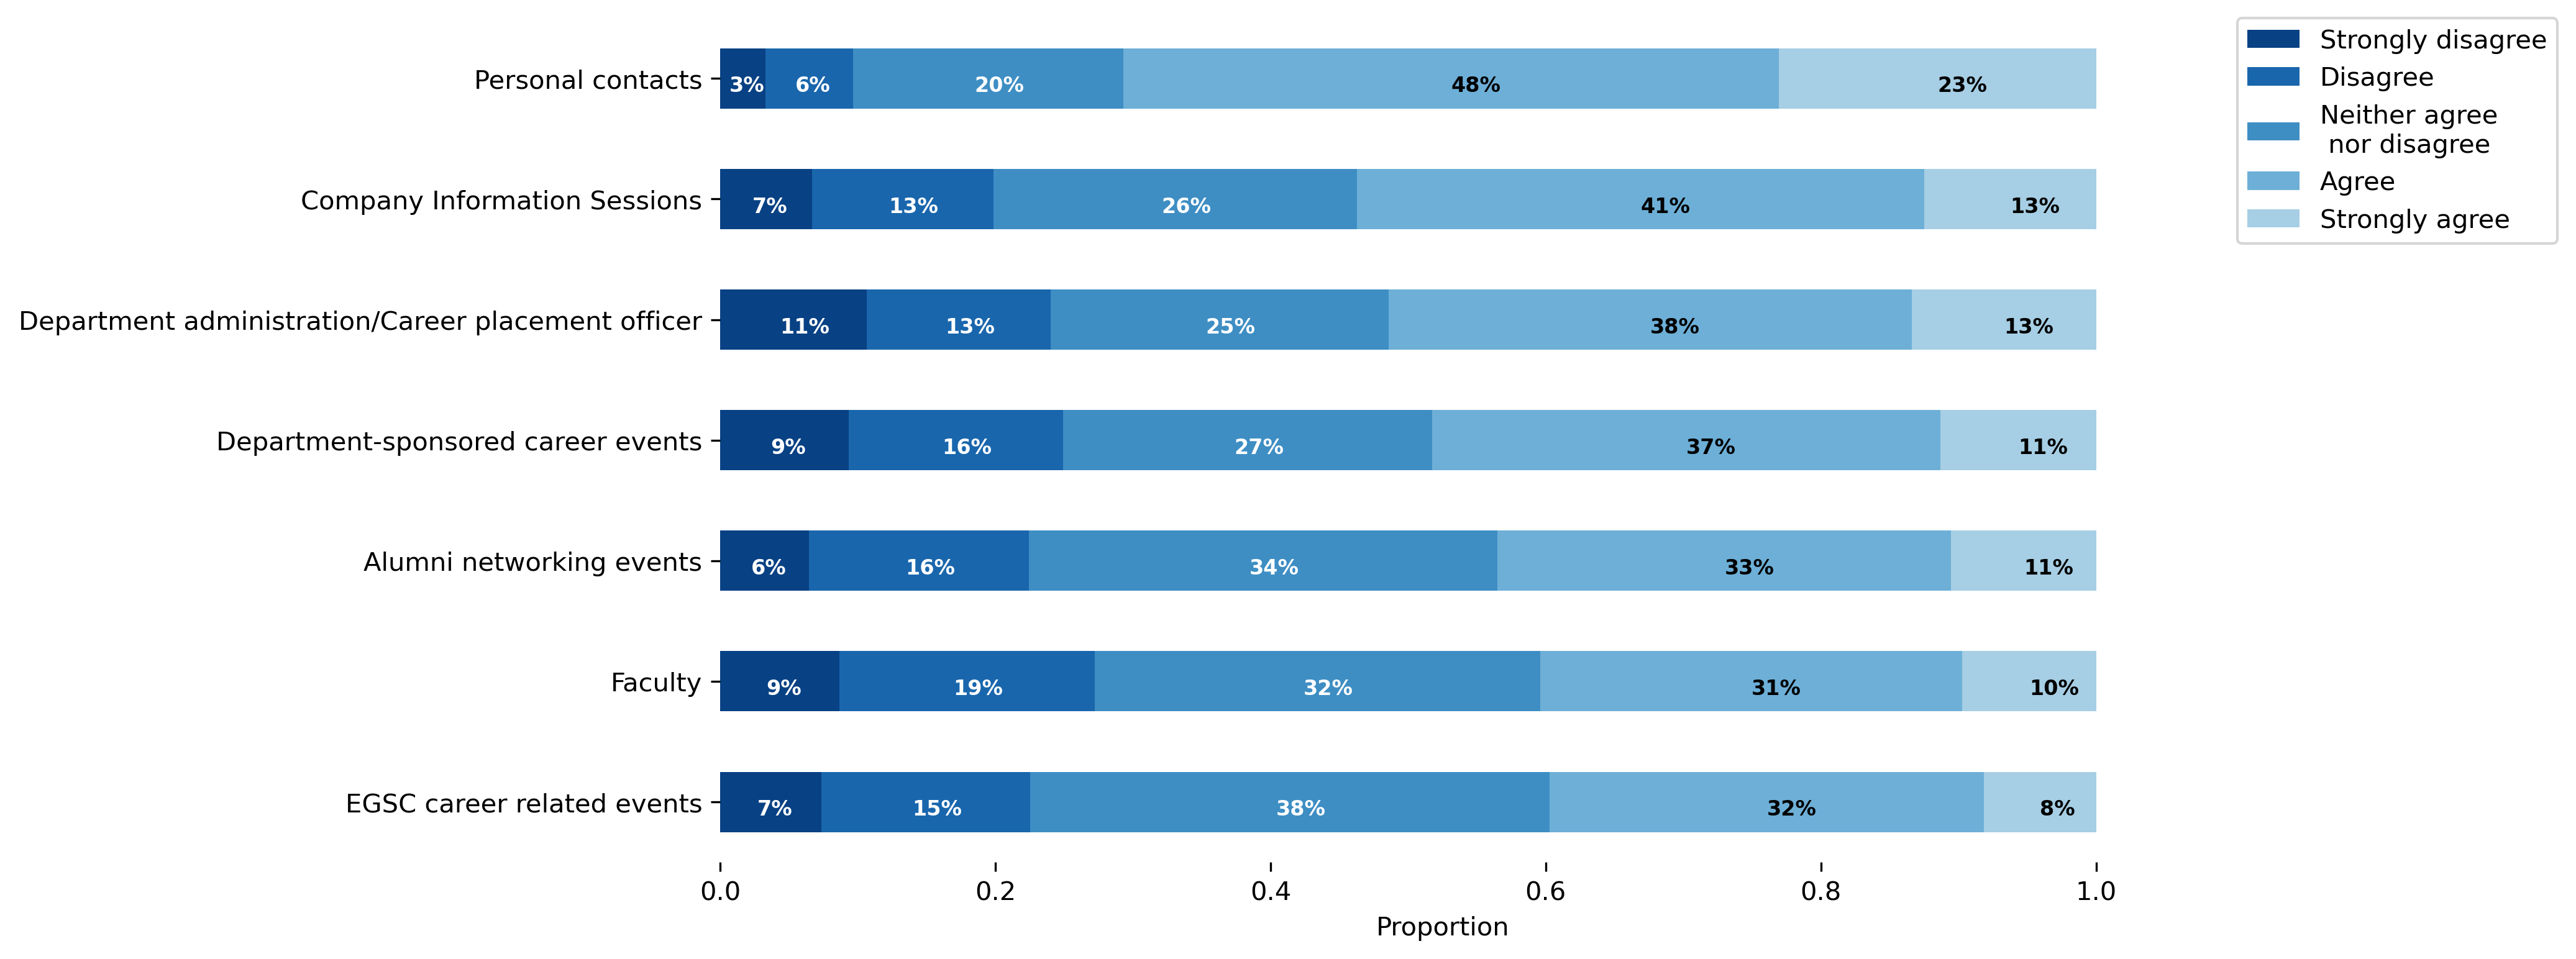

In [781]:
lokres=jobres[jobres['looking']!="No"].drop(columns="looking")
lokres_count=lokres.apply(pd.value_counts,axis=0)
d_=lokres_count[(lokres_count.iloc[3:,:].sum()).sort_values().index]
b_prob=d_.apply(lambda x: x / x.sum(), axis=0)
aaa=d_.T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

The following Graduate Career Placement (GCP) resources have been/were useful in my job search and application process.


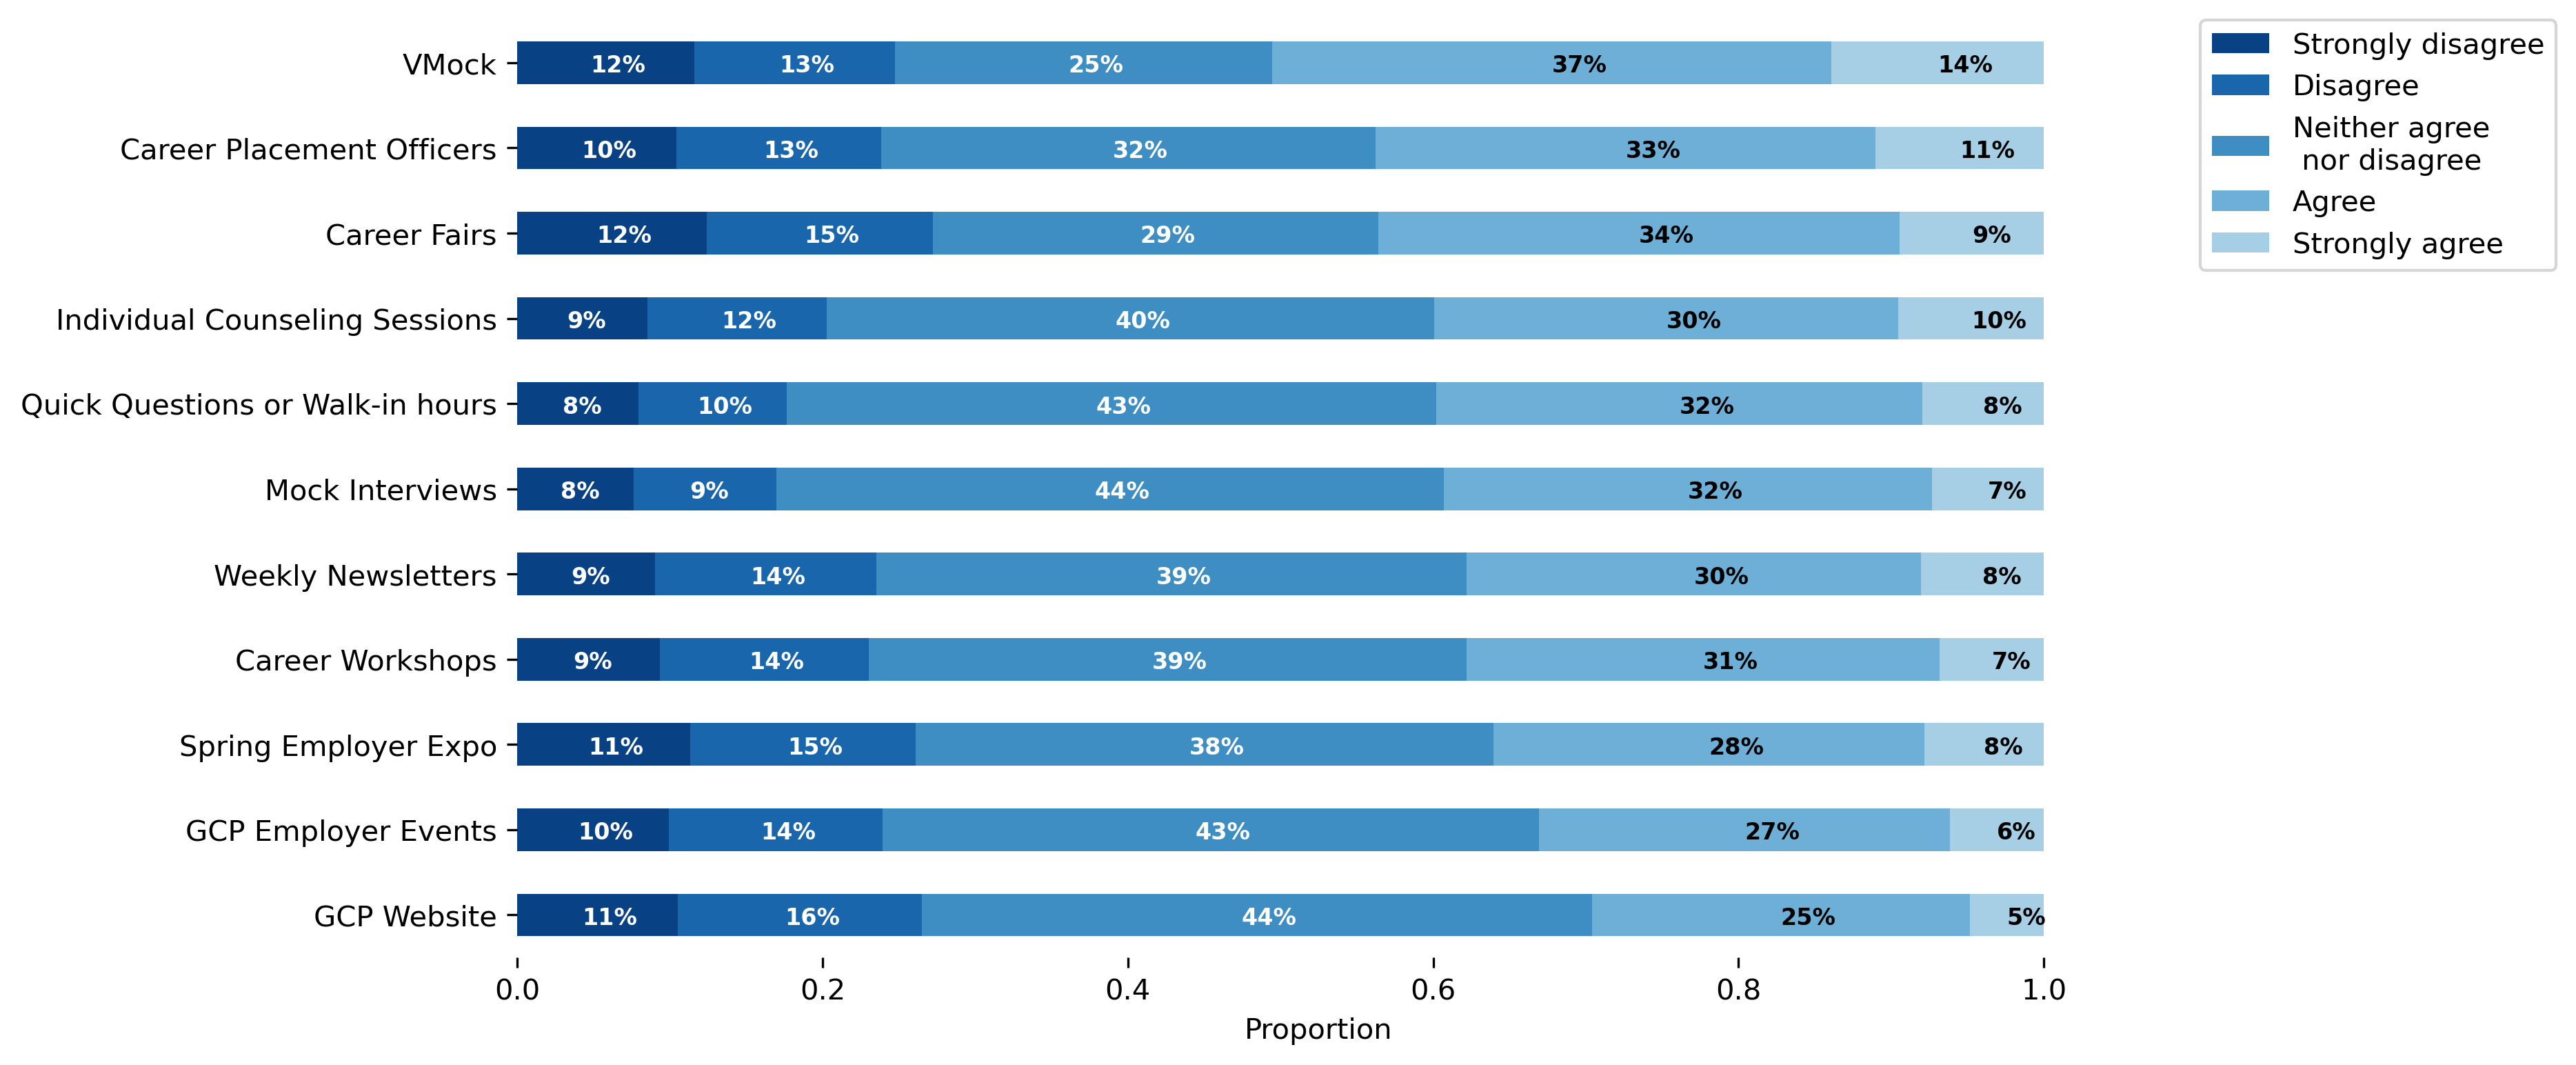

In [783]:
gcpres=query_data(Q,qq,cleaned_data,"job search",indx=2)
gcpres['looking']=lookingforjob
lokgcp=gcpres[gcpres['looking']!="No"].drop(columns="looking")
lokgcp_count=lokgcp.apply(pd.value_counts,axis=0)
d_=lokgcp_count[(lokgcp_count.iloc[3:,:].sum()).sort_values().index]
b_prob=d_.apply(lambda x: x / x.sum(), axis=0)
aaa=d_.T
bbb=b_prob.T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()